In [19]:
%load_ext autoreload
%autoreload 2

# Conditional VAE for genetic circuits

This notebook follows the previous VAE notebook very closely, but implementing a conditional VAE instead. Loosely following [this blog post](https://agustinus.kristia.de/techblog/2016/12/17/conditional-vae/) with the associated [github](https://github.com/wiseodd/generative-models/blob/master/VAE/conditional_vae/cvae_pytorch.py).

## Imports 

In [1]:
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.data.data_format_tools.common import write_json
import itertools
from functools import partial

from sklearn.metrics import r2_score
import os

USE_ONLY_ONE_GPU = False
if USE_ONLY_ONE_GPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # 0 or 1

import sys
import numpy as np
import jax
import umap

from datetime import datetime
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt


jax.config.update('jax_platform_name', 'cpu')


# if __package__ is None:

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)

PRNG = jax.random.PRNGKey(0)

jax.devices()

# jupyter nbconvert --to notebook --execute 01_cvae.ipynb --output=01_cvae_2.ipynb --ExecutePreprocessor.timeout=-1




2025-03-10 13:41:11.969351: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741614072.008656 2934725 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741614072.020728 2934725 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
CUDA backend failed to initialize: INTERNAL: no supported devices found for platform CUDA.(Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[CpuDevice(id=0)]

In [2]:
from evoscaper.scripts.init_from_hpos import init_from_hpos, make_loss
from evoscaper.model.sampling import sample_reconstructions
from evoscaper.scripts.cvae_scan import test
from evoscaper.utils.math import bin_to_nearest_edge, arrayise
from evoscaper.utils.preprocess import make_datetime_str
from evoscaper.utils.optimiser import make_optimiser
from evoscaper.utils.train import train


## Load data

In [3]:
# from evoscaper.scripts.simulate_circuits import summarise_simulated_cicruits, save
# from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict

# analytics = load_json_as_dict('data/simulate_circuits/2025_01_29__18_12_38/analytics.json')
# config = load_json_as_dict('data/simulate_circuits/2025_01_29__18_12_38/config.json')
# interactions = np.load('data/simulate_circuits/2025_01_29__18_12_38/interactions.npy')
# data = summarise_simulated_cicruits(analytics, config, interactions)
# save({'tabulated_mutation_info.json': data}, 'data/simulate_circuits/2025_01_29__18_12_38')

In [4]:
# fn = '../data/raw/summarise_simulation/2024_11_21_144918/tabulated_mutation_info.csv'
# fn = '../data/raw/summarise_simulation/2024_11_21_160955/tabulated_mutation_info.csv'
# fn = '../data/raw/summarise_simulation/2024_12_05_210221/tabulated_mutation_info.csv'
# fn = './data/simulate_circuits/2025_01_29__18_12_38/tabulated_mutation_info.json'
# fn_test_data = '../data/raw/summarise_simulation/2023_07_17_222747/tabulated_mutation_info.csv'
# data = pd.concat([pd.read_csv(fn), pd.read_csv(fn_test_data)])
# data = pd.read_json(fn)
# len(data)

## Hyperparameters

In [5]:
task = 'ds0129_sp_hs32_nl3_KL2e4_cont1ts08pd3'
t_str = make_datetime_str()
top_write_dir = os.path.join('data', '01_cvae', t_str)
save_path = os.path.join(top_write_dir, 'saves_' + t_str + f'_{task}')
os.makedirs(top_write_dir, exist_ok=True)


In [6]:
data_dir = '../data'

hpos_architecture = {
    'seed_arch': 1,
    'hidden_size': 32,
    'enc_ls': 32,
    'dec_ls': 32,
    'num_enc_layers': 3,
    'num_dec_layers': 3,
    'factor_expanding_ls': 1,
    'factor_contracting_ls': 1,
    'model': 'CVAE',
    'use_sigmoid_decoder': False,
    'enc_init': 'HeNormal',
    'dec_init': 'HeNormal',
    'init_model_with_random': True,
    'activation': 'leaky_relu',
}

hpos_training = {
    'seed_train': 1,
    'batch_size': 256,
    'epochs': 1000,
    'patience': 500,
    'threshold_early_val_acc': 0.97,
    'learning_rate': 1e-2,
    'loss_func': 'mse',
    'accuracy_func': 'accuracy_regression',
    'use_dropout': False,
    'dropout_rate': 0.1,
    'use_l2_reg': False,
    'l2_reg_alpha': 5e-2,
    'use_kl_div': True,
    # inspired by https://github.com/elttaes/VAE-MNIST-Haiku-Jax/blob/main/cVAE_mnist.ipynb
    'kl_weight': 2e-4,
    'use_grad_clipping': False,
    'use_contrastive_loss': True,
    'temperature': 1,
    'contrastive_func': 'info_nce',
    'threshold_similarity': 0.8,
    'power_factor_distance': 3
}

hpos_training['print_every'] = hpos_training['epochs'] // 50

hpos_optimization = {
    'seed_opt': 1,
    'opt_method': 'adam',
    'opt_min_lr': 1e-6,
    'opt_min_delta': 1e-4,
    'learning_rate_sched': 'cosine_decay',
    'use_warmup': True,
    'warmup_epochs': 20,
}

hpos_dataset = {
    'seed_dataset': 1,
    'include_diffs': False,
    'objective_col': ('Log sensitivity', 'Log precision'),
    # 'objective_col': 'adaptation',
    # 'objective_col': ('Log sensitivity', 'overshoot'),
    # 'objective_col': ('Log sensitivity > 0', 'Log precision > 1'),
    # 'objective_col': 'Log sensitivity',
    # 'objective_col': ('Log sensitivity', 'Log precision', 'overshoot/initial'),
    # 'objective_col': ('Log sensitivity', 'Log ruggedness (Log sensensitivity)'),
    'output_species': ('RNA_2',),
    'signal_species': ('RNA_0',),
    # 'filenames_train_config': f'{data_dir}/raw/summarise_simulation/2024_11_21_160955/ensemble_config.json',
    # 'filenames_train_table': f'{data_dir}/raw/summarise_simulation/2024_11_21_160955/tabulated_mutation_info.csv',
    # 'filenames_train_config': f'{data_dir}/raw/summarise_simulation/2024_12_05_210221/ensemble_config.json',
    # 'filenames_train_table': f'{data_dir}/raw/summarise_simulation/2024_12_05_210221/tabulated_mutation_info.csv',
    'filenames_train_config': f'./data/simulate_circuits/2025_01_29__18_12_38/config.json',
    'filenames_train_table': f'./data/simulate_circuits/2025_01_29__18_12_38/tabulated_mutation_info.json',
    # 'filenames_train_config': f'./data/simulate_circuits/2025_02_11__13_56_51/config.json',
    # 'filenames_train_table': f'./data/simulate_circuits/2025_02_11__13_56_51/tabulated_mutation_info.json',
    'filenames_verify_config': f'{data_dir}/raw/summarise_simulation/2024_11_21_160955/ensemble_config.json',
    'filenames_verify_table': f'{data_dir}/raw/summarise_simulation/2024_11_21_160955/tabulated_mutation_info.csv',
    'use_test_data': False,
    # 'total_ds': None,   # TO BE RECORDED
    'total_ds_max': 5e6,
    'train_split': 0.8,
    'x_type': 'energies',
    # XY filtering:
    'filt_x_nans': True,
    'filt_y_nans': True,
    'filt_sensitivity_nans': True,
    'filt_precision_nans': True,
    'filt_n_same_x_max': 1,
    'filt_n_same_x_max_bins': None,
    'filt_response_time_high': True,
    'filt_response_time_perc_max': 0.8,
    # XY preprocessing:
    'prep_x_standardise': False,
    'prep_y_standardise': False,
    'prep_x_min_max': True,
    'prep_y_min_max': True,
    'prep_x_robust_scaling': True,
    'prep_y_robust_scaling': True,
    'prep_x_logscale': False,
    'prep_y_logscale': False,
    'prep_x_categorical': False,
    'prep_y_categorical': False,
    'prep_x_categorical_onehot': False,
    'prep_y_categorical_onehot': False,
    'prep_x_categorical_n_bins': 5,
    'prep_y_categorical_n_bins': 5,
    'prep_x_categorical_method': 'quantile',
    'prep_y_categorical_method': 'quantile',
    'prep_x_negative': True,
    'prep_y_negative': False
}

hpos_eval = {
    'eval_n_to_sample': 1e3,
    'eval_cond_min': -0.2,
    'eval_cond_max': 1.2,
    'eval_n_categories': 2,
    'eval_batch_size': int(1e6),
}

info_to_be_recorded = {
    'filename_saved_model': 'TO_BE_RECORDED',
    'total_ds': 'TO_BE_RECORDED',
    'n_batches': 'TO_BE_RECORDED',
    'R2_train': 'TO_BE_RECORDED',
    'R2_test': 'TO_BE_RECORDED',
    'mutual_information_conditionality': 'TO_BE_RECORDED',
    'n_layers_enc': 'TO_BE_RECORDED',
    'n_layers_dec': 'TO_BE_RECORDED',
    'run_successful': 'TO_BE_RECORDED',
    'info_early_stop': 'TO_BE_RECORDED',
    'error_msg': 'TO_BE_RECORDED',
}

hpos_all = {}
for d in [hpos_architecture, hpos_training, hpos_optimization, hpos_dataset, hpos_eval, info_to_be_recorded]:
    hpos_all.update(d)

with open(os.path.join(top_write_dir, 'hpos_all.json'), 'w') as f:
    json.dump(hpos_all, f, indent=4)
hpos = pd.Series(hpos_all)

# Initialise

## Init data

In [7]:
(
    rng, rng_model, rng_dataset,
    config_norm_x, config_norm_y, config_filter, config_optimisation, config_dataset, config_training, config_model,
    data, x_cols, df,
    x, cond, y, x_train, cond_train, y_train, x_val, cond_val, y_val,
    total_ds, n_batches, BATCH_SIZE, x_datanormaliser, x_methods_preprocessing, y_datanormaliser, y_methods_preprocessing,
    params, encoder, decoder, model, h2mu, h2logvar, reparam
) = init_from_hpos(hpos)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Visualise

/tmp/ipykernel_2934725/3100235877.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=df[k], y=df[x_cols].min(axis=1), palette='viridis', bins=50)
/tmp/ipykernel_2934725/3100235877.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=df[k], y=df[x_cols].min(axis=1), palette='viridis', bins=50)


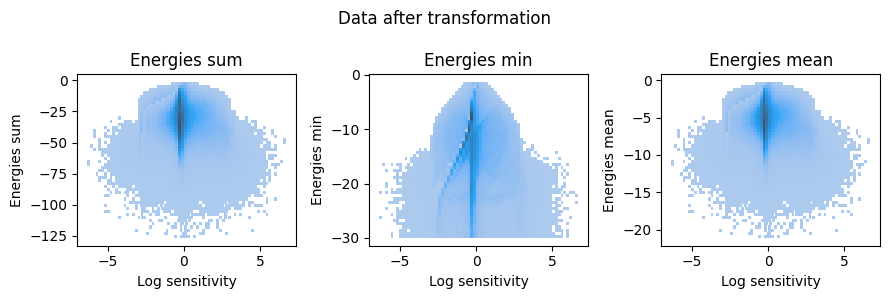

In [8]:
plt.figure(figsize=(3*3, 3))
ax = plt.subplot(1, 3, 1)
for k in config_dataset.objective_col:
    sns.histplot(x=df[k], y=df[x_cols].sum(axis=1), bins=50)
if config_norm_x.logscale:
    plt.xscale('log')
plt.ylabel('Energies sum')
plt.title('Energies sum')
ax = plt.subplot(1, 3, 2)
for k in config_dataset.objective_col:
    sns.histplot(x=df[k], y=df[x_cols].min(axis=1), palette='viridis', bins=50)
    # hue=df[x_cols].mean(axis=1))
if config_norm_x.logscale:
    plt.xscale('log')
plt.ylabel('Energies min')
plt.title('Energies min')
ax = plt.subplot(1, 3, 3)
for k in config_dataset.objective_col:
    sns.histplot(x=df[k], y=df[x_cols].mean(axis=1), bins=50)
if config_norm_x.logscale:
    plt.xscale('log')
plt.ylabel('Energies mean')
plt.title('Energies mean')

plt.suptitle('Data after transformation')
plt.tight_layout()
plt.show()


### Reduce circuits that are overrepresented

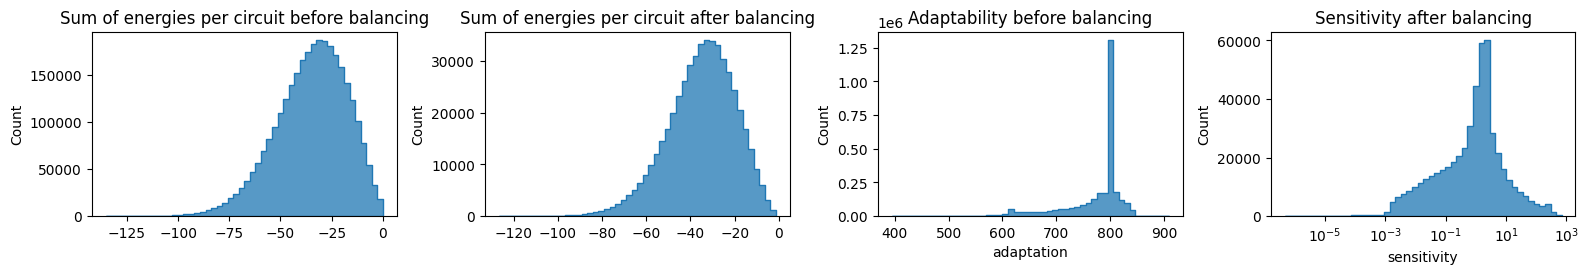

In [9]:
fig = plt.figure(figsize=(4*4, 3))
ax = plt.subplot(1,4,1)
sns.histplot(data[x_cols].sum(axis=1), bins=50, log_scale=[False, False], element='step')
plt.title('Sum of energies per circuit before balancing')
# ylim = ax.get_ylim()
ax = plt.subplot(1,4,2)
sns.histplot(df[x_cols].sum(axis=1), bins=50, log_scale=[False, False], element='step')
plt.title('Sum of energies per circuit after balancing')
# plt.ylim(ylim)
ax = plt.subplot(1,4,3)
sns.histplot(data, x='adaptation', bins=50, log_scale=[False, False], element='step')
plt.title('Adaptability before balancing')
ax = plt.subplot(1,4,4)
sns.histplot(df, x='sensitivity', bins=50, log_scale=[True, False], element='step')
plt.title('Sensitivity after balancing')
plt.tight_layout()
plt.show()


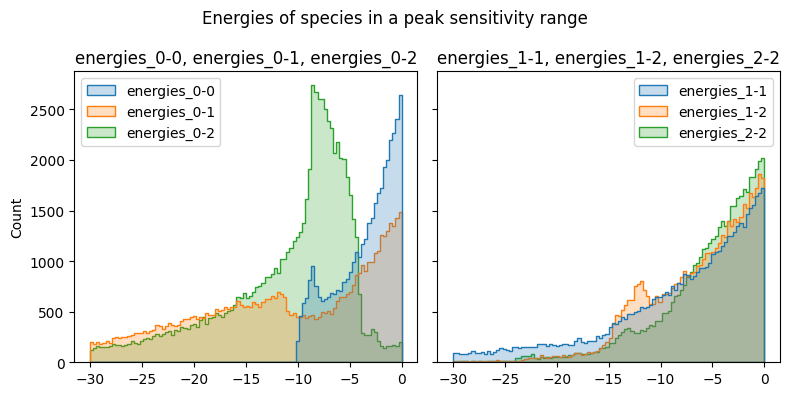

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(2*4, 4), sharex=True, sharey=True)

sns.histplot(df[df[x_cols] != 0][df['Log sensitivity'].between(*df['Log sensitivity'].mode().iloc[0] + np.array([-0.1, 0.1]))][x_cols[:3]], bins=100, element='step',
             ax=axs[0], log_scale=[False, False])
axs[0].set_title(', '.join(x_cols[:3]))
sns.histplot(df[df[x_cols] != 0][df['Log sensitivity'].between(*df['Log sensitivity'].mode().iloc[0] + np.array([-0.1, 0.1]))][x_cols[3:]], bins=100, element='step',
             ax=axs[1], log_scale=[False, False])
axs[1].set_title(', '.join(x_cols[3:]))
plt.suptitle('Energies of species in a peak sensitivity range')
plt.tight_layout()
plt.show()

### Reduce the number of null circuits

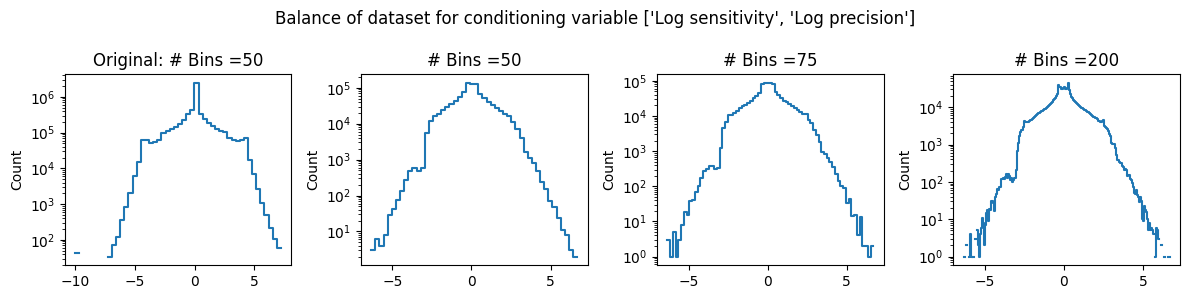

In [11]:
# Balance by bins
nbin = 50
bin_max = int(np.power(10, 4))
# df = balance_dataset(df, cols=config_dataset.objective_col, nbin=nbin, bin_max=bin_max, use_log=False)
# df = balance_dataset(data, cols=X_COLS, nbin=300, bin_max=bin_max, use_log=False, func1=lambda x: np.sum(x, axis=1))

fig = plt.figure(figsize=(4*3, 3))
ax = plt.subplot(1,4,1)
sns.histplot(data[config_dataset.objective_col].to_numpy().flatten(), bins=50, log_scale=[False, True], element='step', fill=False)
plt.title('Original: # Bins =' + str(50))
ax = plt.subplot(1,4,2)
sns.histplot(df[config_dataset.objective_col].to_numpy().flatten(), bins=nbin, log_scale=[False, True], element='step', fill=False)
plt.title('# Bins =' + str(nbin))
ax = plt.subplot(1,4,3)
sns.histplot(df[config_dataset.objective_col].to_numpy().flatten(), bins=int(nbin*1.5), log_scale=[False, True], element='step', fill=False)
plt.title('# Bins =' + str(int(nbin*1.5)))
ax = plt.subplot(1,4,4)
sns.histplot(df[config_dataset.objective_col].to_numpy().flatten(), bins=nbin*4, log_scale=[False, True], element='step', fill=False)
plt.title('# Bins =' + str(nbin*4))

plt.suptitle('Balance of dataset for conditioning variable ' + str(config_dataset.objective_col))
plt.tight_layout()
plt.show()


### Scale the input data

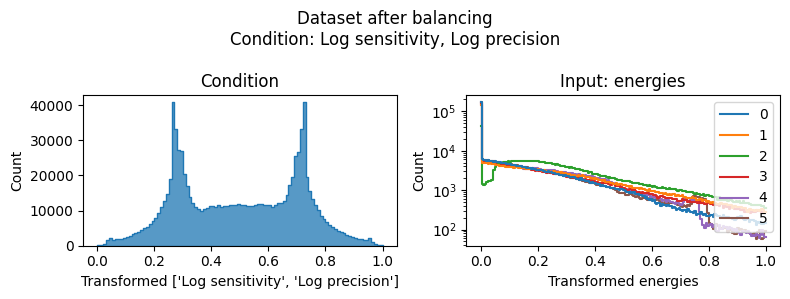

In [12]:
fig = plt.figure(figsize=(2*4, 3))

ax = plt.subplot(1,2,1)
sns.histplot(cond.flatten(), log_scale=[False, False], bins=100, element='step', fill=True)
plt.title(f'Condition')
plt.xlabel(f'Transformed {config_dataset.objective_col}')

ax = plt.subplot(1,2,2)
sns.histplot(x.reshape(np.prod(x.shape[:-1]), -1), element='step', fill=False, bins=200, log_scale=[False, True])
plt.title(f'Input: {config_dataset.x_type}')
plt.xlabel(f'Transformed {config_dataset.x_type}')

plt.suptitle(f'Dataset after balancing\nCondition: {", ".join(config_dataset.objective_col)}')
plt.tight_layout()
plt.show()

## Init optimiser

In [13]:
optimiser = make_optimiser(config_optimisation.learning_rate_sched, config_training.learning_rate,
                           config_training.epochs, config_training.l2_reg_alpha, config_optimisation.use_warmup,
                           config_optimisation.warmup_epochs, n_batches, config_optimisation.opt_method)
optimiser_state = optimiser.init(params)

# Losses
loss_fn, compute_accuracy = make_loss(
    config_training.loss_func, config_training.use_l2_reg, config_training.use_kl_div, config_training.kl_weight)

dummy_x = jax.random.normal(PRNG, x.shape)
dummy_cond = jax.random.normal(PRNG, cond.shape)

In [14]:
h = encoder(params, PRNG, np.concatenate([x, cond], axis=-1))

In [15]:
model(params, PRNG, x, cond, return_all=False).shape

(1971, 256, 6)

In [16]:
# fig = plt.figure(figsize=(3*6, 4))
# i_model = model(params, PRNG, dummy_x, dummy_cond)
# plt.subplot(1,3,1)
# sns.histplot(i_model.flatten(), bins=100, log_scale=[True, False], element='step', fill=False)
# plt.title('Initial output of model (log)')
# plt.subplot(1,3,2)
# sns.histplot(i_model.reshape(np.prod(i_model.shape[:-1]), -1), bins=100, log_scale=[False, False], element='step', fill=False)
# # sns.histplot(model(params, PRNG, x, cond), bins=100, log_scale=[True, False], element='step', fill=False)
# plt.title('Initial output of model')
# plt.subplot(1,3,3)
# i_enc = encoder(params, PRNG, np.concatenate([dummy_x, dummy_cond], axis=-1))
# sns.histplot(i_enc.reshape(np.prod(i_enc.shape[:-1]), -1), bins=100, log_scale=[False, True], element='step', fill=False, legend=False)
# plt.title('Initial embedding of model')
# plt.suptitle(f'Weight init with dummy xy using {config_model.dec_init} and activation {config_model.activation}')


In [17]:
# fig = plt.figure(figsize=(3*6, 4))
# plt.subplot(1,3,1)
# i_model = model(params, PRNG, x, cond)
# sns.histplot(i_model.flatten(), bins=100, log_scale=[True, False], element='step', fill=False)
# plt.title('Initial output of model (log)')
# plt.subplot(1,3,2)
# sns.histplot(i_model.reshape(np.prod(i_model.shape[:-1]), -1), bins=100, log_scale=[False, False], element='step', fill=False)
# # sns.histplot(model(params, PRNG, x, cond), bins=100, log_scale=[True, False], element='step', fill=False)
# plt.title('Initial output of model')
# plt.subplot(1,3,3)
# i_enc = encoder(params, PRNG, np.concatenate([x, cond], axis=-1))
# sns.histplot(i_enc.reshape(np.prod(i_enc.shape[:-1]), -1), bins=100, log_scale=[False, True], element='step', fill=False, legend=False)
# plt.title('Initial embedding of model')
# plt.suptitle(f'Weight init with actual xy using {config_model.dec_init} and activation {config_model.activation}')

In [18]:
# Potential diagnostic code
def print_layer_stats(model):
    for name, module in model.items():
        if 'w' in module:
            print(f"Layer {name}:")
            print(f"  Weight mean: {module['w'].mean().item()}")
            print(f"  Weight std: {module['w'].std().item()}")

# print_layer_stats(params)

# Train

In [19]:
tstart = datetime.now()
params, saves, info_early_stop = train(params, rng, model,
                                       x_train, cond_train, y_train, x_val, cond_val, y_val,
                                       optimiser, optimiser_state, config_training,
                                       epochs=config_training.epochs, loss_fn=loss_fn, compute_accuracy=compute_accuracy,
                                       save_every=config_training.print_every, include_params_in_all_saves=False,
                                       patience=config_training.patience, threshold_early_val_acc=config_training.threshold_early_val_acc)
print(datetime.now() - tstart)

pred_y = model(params, rng, x_train, cond=cond_train)
r2_train = r2_score(y_train.flatten(), pred_y.flatten())

train.py:train():188: Epoch 0 / 1000 -		 Train loss: 0.08026913553476334	Val loss: 0.011098883114755154	Val accuracy: 0.3748829662799835 INFO
train.py:train():198: Early stopping triggered after 5 epochs:
Train loss: -0.03385087102651596
Val loss: -0.03454715013504028
Val accuracy: 0.9705333709716797
Epochs no improvement: 0 WARNING


0:00:11.696414


In [20]:
if False:  # config_dataset.use_test_data:
    data_test = pd.read_csv(config_dataset.filenames_verify_table) if config_dataset.filenames_verify_table.endswith(
        '.csv') else pd.read_json(config_dataset.filenames_verify_table)
    r2_test, mi, kl_div_ave, latent_stats = test(model, params, rng, decoder, saves, data_test,
                                                 config_dataset, config_norm_y, config_model,
                                                 x_cols, config_filter, top_write_dir,
                                                 x_datanormaliser, x_methods_preprocessing,
                                                 y_datanormaliser, y_methods_preprocessing, visualise=False)
    print(r2_test, mi)
    hpos_all['R2_test'] = r2_test

else:
    from evoscaper.scripts.cvae_scan import test_conditionality

    mi, kl_div_ave = test_conditionality(params, rng, decoder,
                                         config_dataset, config_norm_y, config_model,
                                         x_datanormaliser, x_methods_preprocessing, cond,
                                         n_to_sample=int(1e4))
    [print(k, v) for k, v in kl_div_ave.items()]
    print(mi)

Log sensitivity 0.04138048945183812
Log precision 0.04814580775845367
-23.025848


In [21]:
hpos_all['R2_train'] = r2_train
hpos_all['info_early_stop'] = info_early_stop
hpos_all['filename_saved_model'] = save_path
hpos_all['total_ds'] = total_ds
hpos_all['n_batches'] = n_batches
hpos_all['run_successful'] = True
with open(os.path.join(top_write_dir, 'hpos_all.json'), 'w') as f:
    json.dump(hpos_all, f, indent=4)

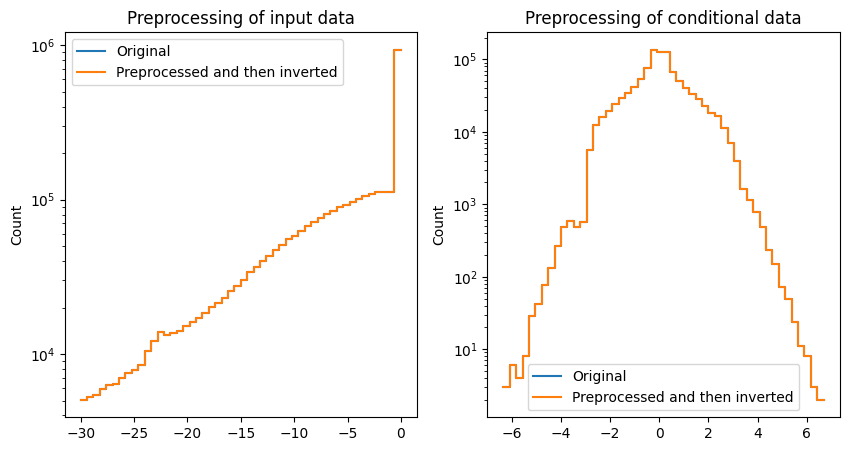

In [22]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
sns.histplot(np.concatenate([df[i].iloc[:total_ds].values[:, None] for i in x_cols], axis=1).squeeze().flatten(), bins=50, log_scale=[False, True], element='step', fill=False, label='Original')
sns.histplot(x_datanormaliser.create_chain_preprocessor_inverse(x_methods_preprocessing)(x).flatten(), bins=50, log_scale=[False, True], element='step', fill=False, label='Preprocessed and then inverted')
plt.legend()
plt.title('Preprocessing of input data')

plt.subplot(1,2,2)
sns.histplot(df[config_dataset.objective_col].iloc[:total_ds].values.flatten(), bins=50, log_scale=[False, True], element='step', fill=False, label='Original')
sns.histplot(np.concatenate([y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(cond[..., i], col=c).flatten() for i, c in enumerate(config_dataset.objective_col)]), 
             bins=50, log_scale=[False, True], element='step', fill=False, label='Preprocessed and then inverted')
plt.legend()
plt.title('Preprocessing of conditional data')

plt.show()

# Visualise

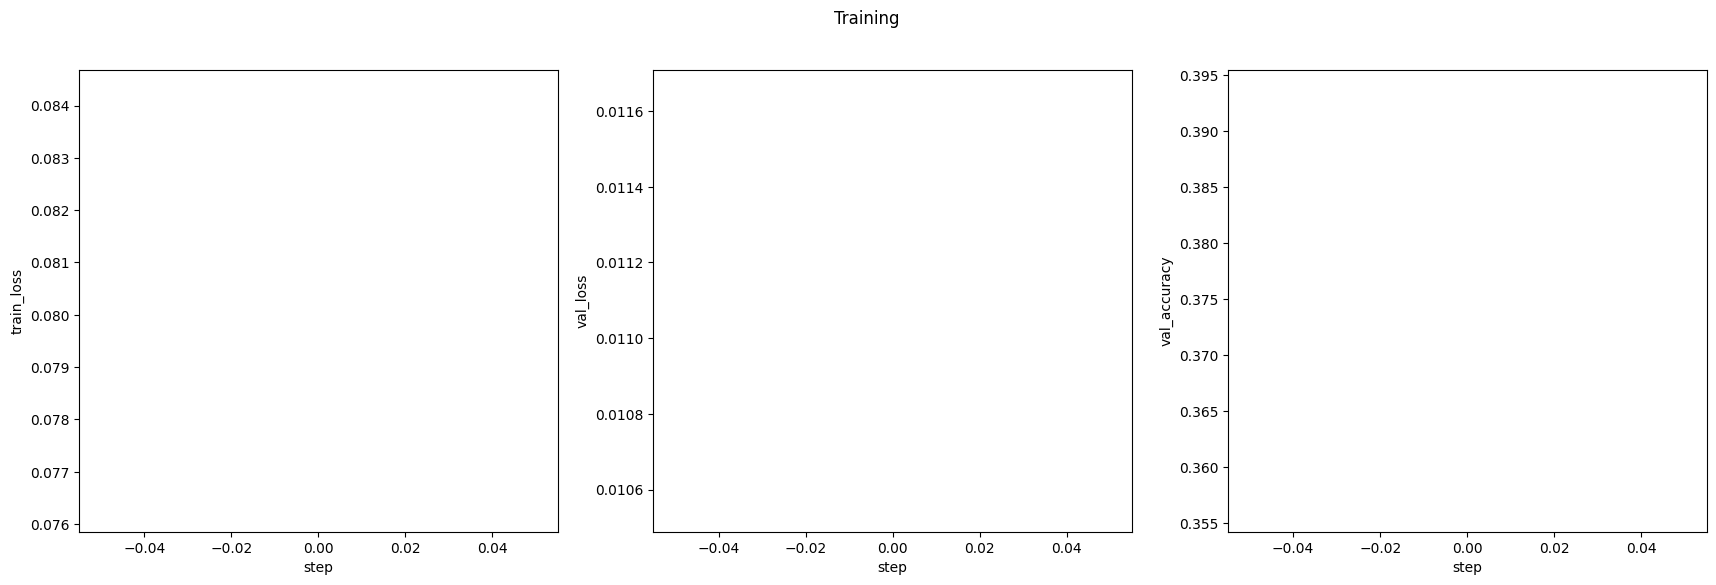

In [23]:
plt.figure(figsize=(7*3, 6))
ax = plt.subplot(1, 3, 1)
plt.plot(list(saves.keys()), [v['train_loss'] for v in saves.values()])
plt.ylabel('train_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 2)
plt.plot(list(saves.keys()), [v['val_loss'] for v in saves.values()])
plt.ylabel('val_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 3)
plt.plot(list(saves.keys()), [v['val_accuracy'] for v in saves.values()])
plt.ylabel('val_accuracy')
plt.xlabel('step')

plt.suptitle('Training')
plt.show()

In [24]:
write_json(saves, out_path=save_path)

In [25]:
print(save_path)


data/01_cvae/2025_03_10__12_06_01/saves_2025_03_10__12_06_01_ds0129_sp_hs32_nl3_KL2e4_cont1ts08pd3


# Examine trained model

In [20]:
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_11_27__15_01_35_saves_test')
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_11_27__16_58_36_saves_test')
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_11_28__14_12_59_saves_test')
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_11_29__10_43_59_saves_test')
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_02__13_49_00_saves_test')  # sensitivity
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_06__14_54_23_saves_test')  # generated from interactions
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_06__17_57_39_saves_test')  # generated from interactions with sigmoid in decoder for 500 epochs
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__17_45_52_saves_no_sigmoid_decoder')  # generated from interactions with sigmoid in decoder for 2000 epochs
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__18_59_40_saves_KL_div')  # generated from interactions + relu + sigmoid + KL divergence
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__20_55_42_saves_no_KL')  # generated from interactions + relu + sigmoid
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__21_21_04_saves_no_KL')  # generated from interactions + relu 
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__22_17_13_saves_leaky_relu')  # generated from interactions + leaky relu 
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__22_48_33_saves_KL_leakyrelu')  # generated from interactions + leaky relu + KL
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__23_01_53_saves_KL_leakyrelu')  # generated from interactions + leaky relu + KL + encoder head hidden size
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_09__14_24_25_saves_new_MLP')  # generated from interactions + new MLP
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_09__15_28_08_saves_layers_1')  # generated from interactions + only 1 layer for enc and dec
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_09__15_51_40_saves_he_init')  # generated from interactions + only 1 layer for enc and dec
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_09__16_13_34_saves_he_init_KL_ls1')  # generated from interactions + only 1 layer for enc and dec + KL
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_09__16_49_29_saves_robust_KL_e2000')  # generated from interactions + KL + robust scaling + 2000 epochs
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_09__22_09_41_saves_nosigmoid_KL_new_reparam')  # generated from interactions + KL + no sigmoid + new reparameterisation function + sensitivity ---> DID NOT WORK, NANS
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_09__23_27_37_saves_sens_brd_KL_weight')  # generated from interactions + KL + no sigmoid + new reparameterisation function + sensitivity ---> DID NOT WORK, NANS
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_10__13_36_05_saves_sens_brd_KL_weight')  # generated from interactions + no sigmoid + new reparameterisation function + sensitivity 500 epochs
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_10__14_31_37_saves_sens_en_lr1e3')  # generated from interactions + log sensitivity 3000 epochs + lr 1e-3
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_10__14_45_23_saves_sens_en_lr1e3')  # generated from interactions + log sensitivity 3000 epochs + lr 1e-3 + KL + 3 layers instead of 1
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_10__17_00_32_saves_onehot')  # generated from interactions + log sensitivity + energies + onehot
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_10__17_46_49_saves_onehot_lr1e1')  # generated from interactions + log sensitivity + energies + onehot + lr 1e-1
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_10__17_53_31_saves_onehot_nominmax')  # generated from interactions + log sensitivity + energies + onehot + lr 1e-1 + no minmax just robust scaling
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_10__18_20_05_saves_onehot_minmax_epochs10k')  # generated from interactions + log sensitivity + energies + onehot + lr 1e-1 + 10k epochs + minmax
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_10__21_59_51_saves_onehot_quantile')  # generated from interactions + log sensitivity + onehot + quantile categorical + lr 1e-1 + 10k epochs + minmax
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_11__11_39_29_saves_log_sens_sigmoid_nocat')  # generated from interactions + log sensitivity + no onehot + lr 5e-2 + 10k epochs + minmax + sigmoid
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_11__14_22_59_saves_winit_glorot')  # generated from interactions + log sensitivity + no onehot + lr 5e-2 + sigmoid + minmax + glorot init
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_11__15_17_29_saves_henorm_nosig_minmax')  # generated from interactions + log sensitivity + no onehot + lr 1e-1 + minmax + no sigmoid + he normal init
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_11__17_54_40_saves_henorm_nosig_minmax')  # generated from interactions + log sensitivity + no onehot + lr 1e-1 + minmax + no sigmoid + he normal init
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_12__16_17_49_saves_Eneg_henorm_nosigm_nocat')  # generated from interactions + log sensitivity + no onehot + lr 1e-1 + minmax + no sigmoid + he normal init
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_13__10_59_59_saves_Eneg_onehot')  # generated from interactions + log sensitivity + onehot + lr5e-2 + minmax + no sigmoid + he normal init
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_15__18_08_07_saves_Eneg_onehot_ls3')  # generated from interactions + log sensitivity + onehot + lr5e-2 + minmax + no sigmoid + he normal init + 3 layers + hidden size 64
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_15__18_36_21_saves_Eneg_onehot_ls3_hs32')  # generated from interactions + log sensitivity + onehot + lr5e-2 + minmax + no sigmoid + he normal init + 3 layers + hidden size 32
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_17__13_19_13_saves_Eneg_onehot_ls2_hs32')  # generated from interactions + log sensitivity + onehot + lr5e-2 + minmax + no sigmoid + he normal init + 2 layers + hidden size 32
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_17__15_38_11_saves_KLw25e2')  # generated from interactions + log sensitivity + energies negative onehot + lr1e-1 + minmax + no sigmoid + he normal init + 2 layers + hidden size 32 + KL weight 2.5e-2
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_17__16_22_43_saves_KLw25e3')  # generated from interactions + log sensitivity + energies negative onehot + lr5e-2 + minmax + no sigmoid + he normal init + 2 layers + hidden size 32 + KL weight 2.5e-3
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_17__18_48_25_saves_KLw1e3_lr1e1')  # generated from interactions + log sensitivity + energies negative onehot + lr1e-1 + minmax + no sigmoid + he normal init + 2 layers + hidden size 32 + KL weight 1e-3
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_17__19_05_55_saves_KLw5e4_L21e1')  # generated from interactions + log sensitivity + energies negative onehot + lr1e-1 + minmax + no sigmoid + he normal init + 2 layers + hidden size 32 + KL weight 5e-4 + L2 reg
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_18__12_19_07_saves_bug_fix')  # generated from interactions + log sensitivity + energies negative onehot + lr5e-2 + minmax + no sigmoid + he normal init + 2 layers + hidden size 32 + KL weight 2.5e-4
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_18__17_16_40_saves_L25e2_lr1e1')  # generated from interactions + log sensitivity + energies negative onehot + lr1e-1 + minmax + no sigmoid + he normal init + 2 layers + hidden size 32 + KL weight 2.5e-4
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_18__21_17_58_saves_lr1e1_nocat_nsamebins50')  # generated from interactions + log sensitivity + energies negative NO onehot + lr1e-1 + minmax + no sigmoid + he normal init + 3 layers + hidden size 32 + KL weight 2.5e-4 + n x same bins 50
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_18__22_06_02_saves_lr1e1_nocat_nsamebins50_ls3_bs256')  # generated from interactions + log sensitivity + energies negative NO onehot + lr1e-1 + minmax + no sigmoid + he normal init + 3 layers + hidden size 32 + KL weight 2.5e-4 + n x same bins 50
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_19__16_10_53_saves_hs16_ls32_nlayers2_adam')  # generated from interactions + log sensitivity + energies negative onehot + lr1e-2 + minmax + no sigmoid + he normal init + 2 layers + hidden size 16 + ls 32 + KL weight 2.5e-4 + n x same bins 50
fn_saves = os.path.join('weight_saves', '01_cvae', 'saves_2025_01_09__15_33_42_adapt')  # objective col adaptation
fn_saves = os.path.join('weight_saves', '01_cvae', 'saves_2025_01_09__21_26_05_prec_sens')  # objective col sens and prec
fn_saves = os.path.join('weight_saves', '01_cvae', 'saves_2025_01_14__17_44_21_sens')  # objective col log sens 
fn_saves = os.path.join('weight_saves', '01_cvae', 'saves_2025_01_17__16_01_57_sens_no_cat')  # objective col log sens without categorical encoding
fn_saves = os.path.join('weight_saves', '01_cvae', 'saves_2025_01_21__22_40_13_no_cat_sens_prec')  # objective col log sens without categorical encoding
fn_saves = os.path.join('data', '01_cvae', '2025_01_23__15_38_01', 'saves_2025_01_23__15_38_01_sens')  # Redo with just sensitivity + no categorical + no KL (KL did not work)
fn_saves = os.path.join('data', '01_cvae', '2025_01_23__15_42_09', 'saves_2025_01_23__15_42_09_sens_cat')  # Same as above but with categorical (onehot) 
fn_saves = os.path.join('data', '01_cvae', '2025_01_23__15_47_33', 'saves_2025_01_23__15_47_33_sens_kl')  # Same as above but no categorical (onehot) and with KL
fn_saves = os.path.join('data', '01_cvae', '2025_01_23__15_52_15', 'saves_2025_01_23__15_52_15_sens_contloss')  # Same as above but no categorical (onehot) with contrastive loss
fn_saves = os.path.join('data', '01_cvae', '2025_01_24__13_53_02', 'saves_2025_01_24__13_53_02_sens_contloss_t2')  # Same as above but no categorical (onehot) with contrastive loss temperature = 2
fn_saves = os.path.join('data', '01_cvae', '2025_01_24__15_40_26', 'saves_2025_01_24__15_40_26_sens_contloss_t1_5')  # Same as above but no categorical (onehot) with contrastive loss temperature = 1.5
fn_saves = os.path.join('data', '01_cvae', '2025_01_25__12_23_51', 'saves_2025_01_25__12_23_51_sens_kl_25e3')  # Same as above but no categorical (onehot) and with KL weight = 2.5e-3
fn_saves = os.path.join('data', '01_cvae', '2025_01_26__14_20_07', 'saves_2025_01_26__14_20_07_sens_kl_1e3')  # Same as above but no categorical (onehot) and with KL weight = 1e-3
fn_saves = os.path.join('data', '01_cvae', '2025_01_26__16_16_36', 'saves_2025_01_26__16_16_36_sens_kl_8e4')  # Same as above but no categorical (onehot) and with KL weight = 8e-4
fn_saves = os.path.join('data', '01_cvae', '2025_01_26__16_32_02', 'saves_2025_01_26__16_32_02_sens_kl_5e4')  # Same as above but no categorical (onehot) and with KL weight = 5e-4
fn_saves = os.path.join('data', '01_cvae', '2025_01_31__21_46_50', 'saves_2025_01_31__21_46_50_ds2')  # New dataset 2 ('./data/simulate_circuits/2025_01_29__18_12_38/tabulated_mutation_info.json) + no response time filer
fn_saves = os.path.join('data', '01_cvae', '2025_01_31__21_52_42', 'saves_2025_01_31__21_52_42_ds2_resp')  # New dataset 2 ('./data/simulate_circuits/2025_01_29__18_12_38/tabulated_mutation_info.json) + with response time filter
fn_saves = os.path.join('data', '01_cvae', '2025_01_31__23_07_54', 'saves_2025_01_31__23_07_54_ds1_fresp')  # New dataset 1 ('./data/simulate_circuits/2025_01_29__14_52_44/tabulated_mutation_info.json) + with response time filter
fn_saves = os.path.join('data', '01_cvae', '2025_01_31__23_11_09', 'saves_2025_01_31__23_11_09_ds1_thresh95')  # New dataset 1 ('./data/simulate_circuits/2025_01_29__14_52_44/tabulated_mutation_info.json) + with response time filter + threshold 0.95
fn_saves = os.path.join('data', '01_cvae', '2025_02_02__16_05_03', 'saves_2025_02_02__16_05_03_ds3')  # New dataset 3 ('./data/simulate_circuits/2025_02_01__00_22_38/tabulated_mutation_info.json)
fn_saves = os.path.join('data', '01_cvae', '2025_02_02__16_18_20', 'saves_2025_02_02__16_18_20_ds3')  # New dataset 3 ('./data/simulate_circuits/2025_02_01__00_22_38/tabulated_mutation_info.json) --> redid balancing func
fn_saves = os.path.join('data', '01_cvae', '2025_02_02__18_26_09', 'saves_2025_02_02__18_26_09_ds3')  # New dataset 3 ('./data/simulate_circuits/2025_02_01__00_22_38/tabulated_mutation_info.json) forgot to set balancing hpo
fn_saves = os.path.join('data', '01_cvae', '2025_02_02__19_14_12', 'saves_2025_02_02__19_14_12_ds0_ds3test')  # Train with old dataset ds0 (data/raw/summarise_simulation/2024_12_05_210221) and verify with new dataset 3 ('./data/simulate_circuits/2025_02_01__00_22_38/tabulated_mutation_info.json) 
fn_saves = os.path.join('data', '01_cvae', '2025_02_07__17_29_29', 'saves_2025_02_07__17_29_29_dssim1')  # Train with most recent dataset of parameter-based simulation (not sequence-based)
fn_saves = os.path.join('data', '01_cvae', '2025_02_07__22_15_21', 'saves_2025_02_07__22_15_21_dssim0128')  # Train less recent dataset of parameter-based simulation 
fn_saves = os.path.join('data', '01_cvae', '2025_02_08__16_08_44', 'saves_2025_02_08__16_08_44_ds1205')  # Re-do `saves_2025_01_14__17_44_21_sens`
fn_saves = os.path.join('data', '01_cvae', '2025_02_10__22_19_54', 'saves_2025_02_10__22_19_54_ds1205_noKL')  # Re-do `saves_2025_01_14__17_44_21_sens` without KL
fn_saves = os.path.join('data', '01_cvae', '2025_02_11__10_58_50', 'saves_2025_02_11__10_58_50_ds1205_noKL')  # Re-do `saves_2025_01_14__17_44_21_sens` without KL + (sens, overshoot)
fn_saves = os.path.join('data', '01_cvae', '2025_02_11__13_43_57', 'saves_2025_02_11__13_43_57_ds1205_noKL')  # Re-do `saves_2025_01_14__17_44_21_sens` without KL + (sens, overshoot/initial)
fn_saves = os.path.join('data', '01_cvae', '2025_02_11__20_41_02', 'saves_2025_02_11__20_41_02_ds0211')  # New dataset `2025_02_11__13_56_51` with sensitivity
fn_saves = os.path.join('data', '01_cvae', '2025_02_11__20_49_57', 'saves_2025_02_11__20_49_57_ds0211_noneg')  # New dataset `2025_02_11__13_56_51` with sensitivity, no negative prep
fn_saves = os.path.join('data', '01_cvae', '2025_02_17__17_01_05', 'saves_2025_02_17__17_01_05_ds0211')  # New dataset `2025_02_11__13_56_51` sens
fn_saves = os.path.join('data', '01_cvae', '2025_02_23__15_43_06', 'saves_2025_02_23__15_43_06_ds0211_spo')  # New dataset `2025_02_11__13_56_51` sens + prec + adapt
fn_saves = os.path.join('data', '01_cvae', '2025_02_23__17_51_09', 'saves_2025_02_23__17_51_09_ds0211_spbool')  # New dataset `2025_02_11__13_56_51` l sens > 0 + l prec > 1
fn_saves = os.path.join('data', '01_cvae', '2025_02_23__18_21_05', 'saves_2025_02_23__18_21_05_ds0211_spbool_enc1')  # New dataset `2025_02_11__13_56_51` l sens > 0 + l prec > 1 + encoder 1 hidden layer
fn_saves = os.path.join('data', '01_cvae', '2025_02_23__18_41_24', 'saves_2025_02_23__18_41_24_ds0211_spbool_KL2e4')  # New dataset `2025_02_11__13_56_51` l sens > 0 + l prec > 1 + KL 2e-4
fn_saves = os.path.join('data', '01_cvae', '2025_02_25__12_42_34', 'saves_2025_02_25__12_42_34_ds0211_sp_KL2e4')  # New dataset `2025_02_11__13_56_51` sens, prec + KL 2e-4
fn_saves = os.path.join('data', '01_cvae', '2025_03_03__13_46_27', 'saves_2025_03_03__13_46_27_ds0211_spoiss')  # sens + prec + overshoot / initial + initial + steady state
fn_saves = os.path.join('data', '01_cvae', '2025_03_05__14_56_27', 'saves_2025_03_05__14_56_27_ds0211_spbool_KL2e4')  # Redo: new dataset `2025_02_11__13_56_51` l sens > 0 + l prec > 1 + KL 2e-4
fn_saves = os.path.join('data', '01_cvae', '2025_03_05__15_25_23', 'saves_2025_03_05__15_25_23_ds0129_spbool_KL2e4')  # Dataset `2025_01_29__18_12_38` l sens > 0 + l prec > 1 + KL 2e-4
fn_saves = os.path.join('data', '01_cvae', '2025_03_05__16_52_33', 'saves_2025_03_05__16_52_33_ds0211_sp_KL2e4')  # Dataset `2025_02_11__13_56_51` sens + prec + KL 2e-4
fn_saves = os.path.join('data', '01_cvae', '2025_03_05__21_30_13', 'saves_2025_03_05__21_30_13_ds0129_sp_KL2e4')  # Dataset `2025_01_29__18_12_38` sens + prec + KL 2e-4
fn_saves = os.path.join('data', '01_cvae', '2025_03_06__11_56_03', 'saves_2025_03_06__11_56_03_ds0211_spoiss')  # Dataset `2025_02_11__13_56_51` sens + prec + overshoot / initial + initial + steady state + KL 2e-4
fn_saves = os.path.join('data', '01_cvae', '2025_03_06__12_21_49', 'saves_2025_03_06__12_21_49_ds0129_spoiss')  # Dataset `2025_01_29__18_12_38` sens + prec + overshoot / initial + initial + steady state + KL 2e-4
fn_saves = os.path.join('data', '01_cvae', '2025_03_06__14_24_31', 'saves_2025_03_06__14_24_31_ds0211_spo')  # Dataset `2025_02_11__13_56_51` sens + prec + overshoot / initial + KL 2e-4
fn_saves = os.path.join('data', '01_cvae', '2025_03_06__14_38_59', 'saves_2025_03_06__14_38_59_ds0129_spo')  # Dataset `2025_01_29__18_12_38` sens + prec + overshoot / initial + KL 2e-4
fn_saves = os.path.join('data', '01_cvae', '2025_03_07__16_35_20', 'saves_2025_03_07__16_35_20_ds0211_rug_sens')  # Dataset `2025_02_11__13_56_51` sens + log rugg sens + KL 2e-4
fn_saves = os.path.join('data', '01_cvae', '2025_03_08__19_39_24', 'saves_2025_03_08__19_39_24_ds0211_rug_sens_KL5e4')  # Dataset `2025_02_11__13_56_51` sens + log rugg sens + KL 5e-4
fn_saves = os.path.join('data', '01_cvae', '2025_03_09__16_09_20', 'saves_2025_03_09__16_09_20_ds0211_rug_sens_KL1e3')  # Dataset `2025_02_11__13_56_51` sens + log rugg sens + KL 1e-3
fn_saves = os.path.join('data', '01_cvae', '2025_03_09__17_51_32', 'saves_2025_03_09__17_51_32_ds0129_sp_hs24_kl2e4')  # Dataset `2025_01_29__18_12_38` sens + prec + hidden size 24 + KL 2e-4
fn_saves = os.path.join('data', '01_cvae', '2025_03_09__18_11_22', 'saves_2025_03_09__18_11_22_ds0129_sp_hs10_kl2e4')  # Dataset `2025_01_29__18_12_38` sens + prec + hidden size 10 + KL 2e-4
fn_saves = os.path.join('data', '01_cvae', '2025_03_09__19_18_18', 'saves_2025_03_09__19_18_18_ds0129_sp_hs10_kl5e4')  # Dataset `2025_01_29__18_12_38` sens + prec + hidden size 10 + KL 5e-4
fn_saves = os.path.join('data', '01_cvae', '2025_03_09__19_33_56', 'saves_2025_03_09__19_33_56_ds0129_sp_hs16_kl3e4_L2a5e2_nl2')  # Dataset `2025_01_29__18_12_38` sens + prec + hidden size 16 + KL 3e-4 + n layers 2 + L2 5e-2
fn_saves = os.path.join('data', '01_cvae', '2025_03_09__19_40_28', 'saves_2025_03_09__19_40_28_ds0129_sp_hs16_kl3e4_nl2')  # Dataset `2025_01_29__18_12_38` sens + prec + hidden size 16 + KL 3e-4 + n layers 2 + L2 5e-2
fn_saves = os.path.join('data', '01_cvae', '2025_03_09__22_51_48', 'saves_2025_03_09__22_51_48_ds0129_sp_uniform')  # Dataset `2025_01_29__18_12_38` sens + prec + hidden size 16 + KL 3e-4 + n layers 2 + L2 5e-2
fn_saves = os.path.join('data', '01_cvae', '2025_03_10__12_06_01', 'saves_2025_03_10__12_06_01_ds0129_sp_hs32_nl3_KL2e4_cont1ts08pd3')  # Dataset `2025_01_29__18_12_38` sens + prec + hidden size 32 + KL 2e-4 + n layers 3 + contrastive loss temp = 1, power dist = 3
saves_loaded = load_json_as_dict(fn_saves)

p = saves_loaded[str(list(saves_loaded.keys())[-1])]['params']
p = arrayise(p)
# p['vae/~/h2mu'] = p.pop('vae/~/linear')
# p['vae/~/h2logvar'] = p.pop('vae/~/linear_1')

pred_y = model(p, PRNG, x, cond)
pred_y.shape

(1971, 256, 6)

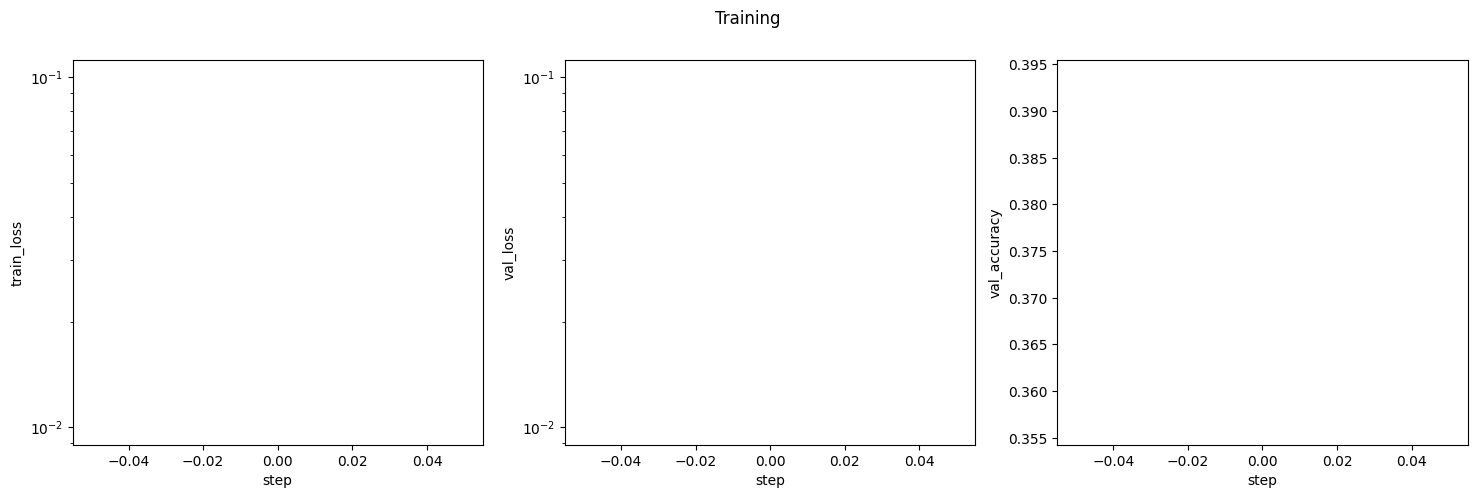

In [21]:
plt.figure(figsize=(6*3, 5))
ax = plt.subplot(1, 3, 1)
plt.plot(list(map(float, saves_loaded.keys())), np.array([float(v['train_loss']) for v in saves_loaded.values()]))
plt.yscale('log')
plt.ylabel('train_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 2)
plt.plot(list(map(float, saves_loaded.keys())), np.array([float(v['val_loss']) for v in saves_loaded.values()]))
plt.yscale('log')
plt.ylabel('val_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 3)
plt.plot(list(map(float, saves_loaded.keys())), np.array([float(v['val_accuracy']) for v in saves_loaded.values()]))
plt.ylabel('val_accuracy')
plt.xlabel('step')
plt.suptitle('Training')

plt.show()


/tmp/ipykernel_2934725/3777022156.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.histplot(x=pred_y.flatten(), y=y.flatten(), palette='viridis', ax=axes[0])


[Training] The R2 score is  0.9628076553344727
[Training] The R2 score with weighted variance is  0.9628076553344727


/tmp/ipykernel_2934725/3777022156.py:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.histplot(x=pred_y_val.flatten(), y=y_val.flatten(), palette='viridis', ax=axes[1])


[Validation] The $R^2$ score is  0.962826132774353
[Validation] The $R^2$ score with weighted variance is  0.962826132774353


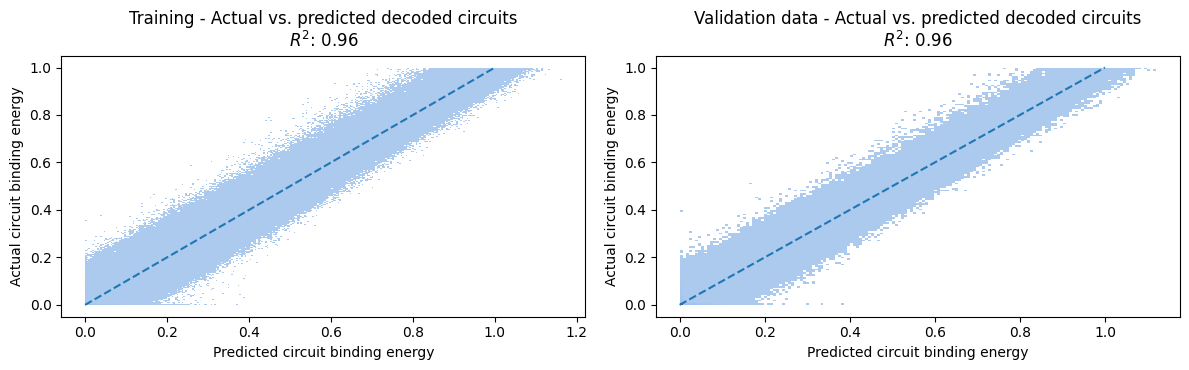

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(2*6, 4))

g = sns.histplot(x=pred_y.flatten(), y=y.flatten(), palette='viridis', ax=axes[0])
axes[0].plot([0, 1], [0, 1], '--')
# g = sns.scatterplot(x=pred_y.flatten(), y=y.flatten(), alpha=0.1, hue=np.sqrt(np.abs(pred_y.flatten() - y.flatten())), palette='viridis')
# g.legend_.set_title('Sqare root of difference')
axes[0].set_title(f'Training - Actual vs. predicted decoded circuits\n$R^2$: {r2_score(y.flatten(), pred_y.flatten()):.2f}')
axes[0].set_xlabel('Predicted circuit binding energy')
axes[0].set_ylabel('Actual circuit binding energy')

print('[Training] The R2 score is ', r2_score(y.flatten(), pred_y.flatten()))
print('[Training] The R2 score with weighted variance is ', r2_score(
    y.flatten(), pred_y.flatten(), multioutput='variance_weighted'))

pred_y_val = model(p, PRNG, x_val, cond_val)

g = sns.histplot(x=pred_y_val.flatten(), y=y_val.flatten(), palette='viridis', ax=axes[1])
axes[1].plot([0, 1], [0, 1], '--')
# g = sns.scatterplot(x=pred_y_val.flatten(), y=y_val.flatten(), alpha=0.1, hue=np.sqrt(np.abs(pred_y_val.flatten() - y_val.flatten())), palette='viridis')
# g.legend_.set_title('Sqare root of difference')
axes[1].set_title(f'Validation data - Actual vs. predicted decoded circuits\n$R^2$: {r2_score(y_val.flatten(), pred_y_val.flatten()):.2f}')
axes[1].set_xlabel('Predicted circuit binding energy')
axes[1].set_ylabel('Actual circuit binding energy')

print(f'[Validation] The $R^2$ score is ', r2_score(y_val.flatten(), pred_y_val.flatten()))
print(f'[Validation] The $R^2$ score with weighted variance is ', r2_score(
    y_val.flatten(), pred_y_val.flatten(), multioutput='variance_weighted'))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(top_write_dir, 'parity.png'), transparent=True, dpi=300)

plt.show()


# Sample fake circuits

In [23]:
n_to_sample = int(1e5)
n_categories = 5

sampled_cond = np.interp(jax.random.normal(PRNG, (n_to_sample, cond.shape[-1])), [0, 1], [cond.min(), cond.max()])
if tuple(config_dataset.objective_col) == ('Log sensitivity > 0', 'Log precision > 1'):
    sampled_cond = np.where(sampled_cond > 0.5, 1, 0)
# mu = np.random.normal(size=(n_to_sample, HIDDEN_SIZE)) * 10
# logvar = np.random.normal(size=(n_to_sample, HIDDEN_SIZE)) * 0.5
# mu = h2mu(p, PRNG, sampled_h) 
# logvar = h2logvar(p, PRNG, sampled_h)
# z = sample_z(mu=mu, logvar=logvar, key=PRNG)
z = jax.random.normal(PRNG, (n_to_sample, config_model.hidden_size))
z = np.concatenate([z, sampled_cond], axis=-1)

fake_circuits = decoder(p, PRNG, z)
# fake_circuits = np.where(fake_circuits > 0, 0, fake_circuits)
sampled_cond.shape, fake_circuits.shape, z.shape

((100000, 2), (100000, 6), (100000, 34))

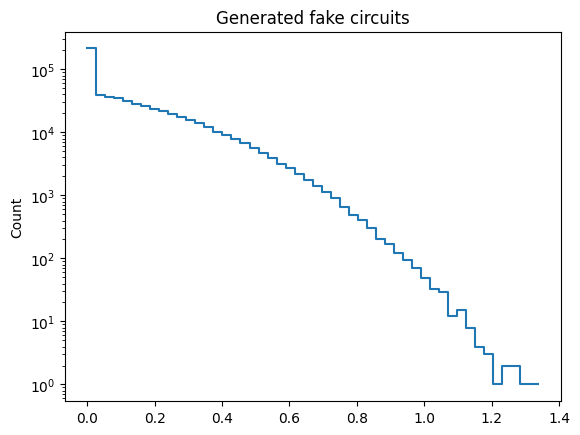

In [24]:
sns.histplot(fake_circuits.flatten(), bins=50, log_scale=[False, True], element='step', fill=False)
plt.title('Generated fake circuits')
plt.show()


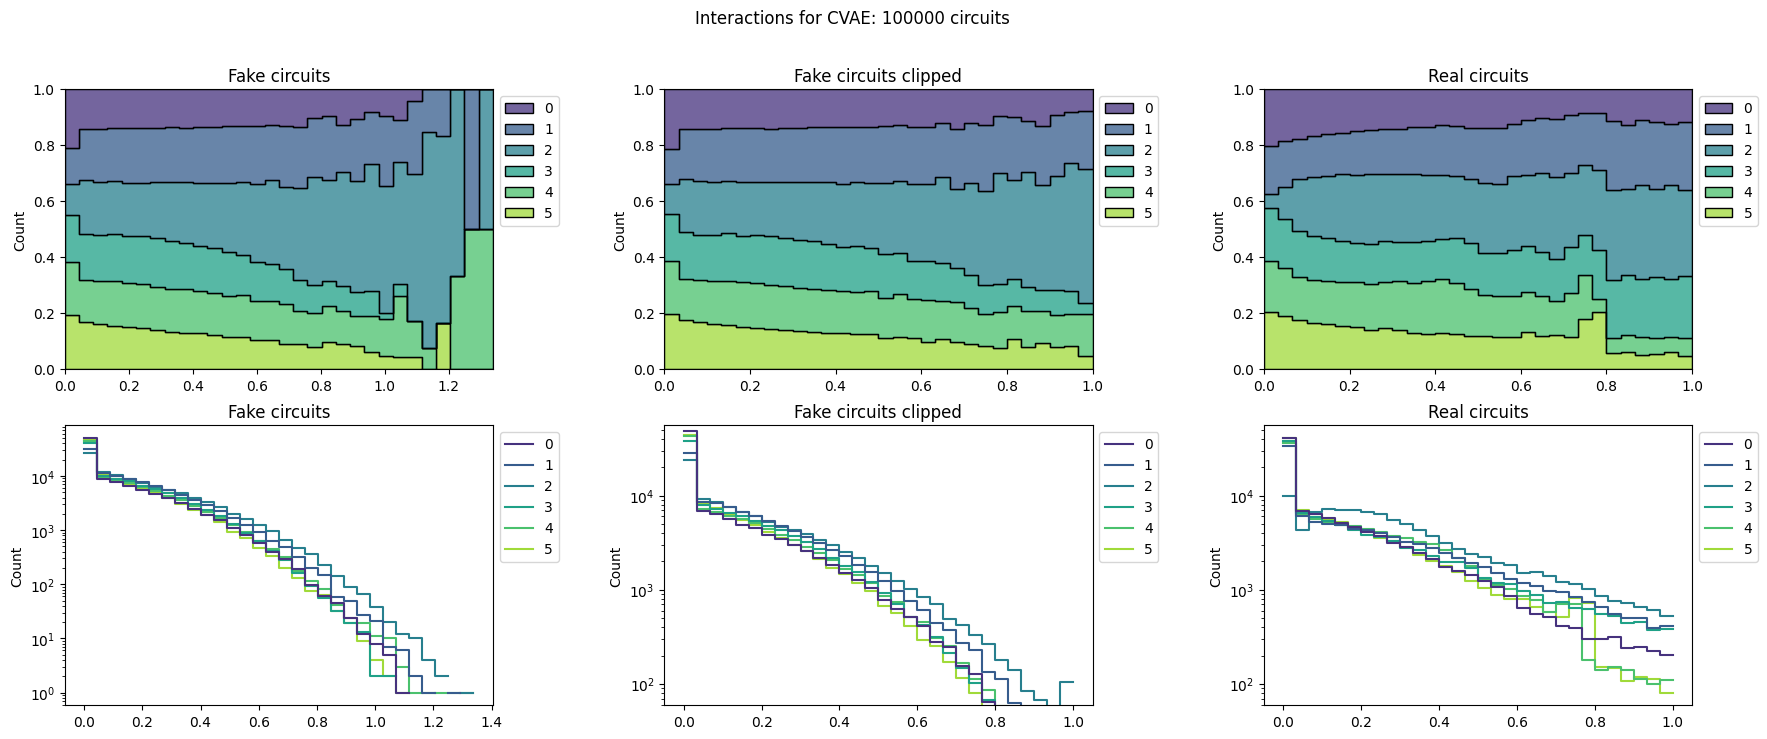

In [25]:
fig = plt.figure(figsize=(7*3, 8))
fig.subplots_adjust(wspace=0.4)

ax = plt.subplot(2, 3, 1)
g = sns.histplot(fake_circuits, element='step', bins=30,
                 palette='viridis', multiple='fill')
plt.title('Fake circuits')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 2)
g = sns.histplot(np.where(fake_circuits > x.max(), x.max(), np.where(fake_circuits < x.min(), x.min(), fake_circuits)), 
                 element='step', bins=30,
                 palette='viridis', multiple='fill')
plt.title('Fake circuits clipped')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 3)
g = sns.histplot(x.reshape(np.prod(x.shape[:-1]), x.shape[-1])[:n_to_sample],
                 element='step', bins=30, palette='viridis', multiple='fill')
plt.title('Real circuits')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 4)
g = sns.histplot(fake_circuits, element='step', bins=30, palette='viridis',
                 multiple='layer', fill=False, log_scale=[False, True])
plt.title('Fake circuits')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 5)
g = sns.histplot(np.where(fake_circuits > x.max(), x.max(), np.where(fake_circuits < x.min(), x.min(), fake_circuits)), 
                 element='step', bins=30, palette='viridis',
                 multiple='layer', fill=False, log_scale=[False, True])
plt.title('Fake circuits clipped')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 6)
x_hist = x.reshape(np.prod(x.shape[:-1]), x.shape[-1])[:n_to_sample]
g2 = sns.histplot(x_hist, element='step', bins=30, palette='viridis',
                  multiple='layer', fill=False, log_scale=[False, True])
plt.title('Real circuits')
sns.move_legend(g2, 'upper left', bbox_to_anchor=(1, 1))

g.set_ylim(g2.get_ylim())

plt.suptitle(f'Interactions for CVAE: {n_to_sample} circuits')

plt.show()


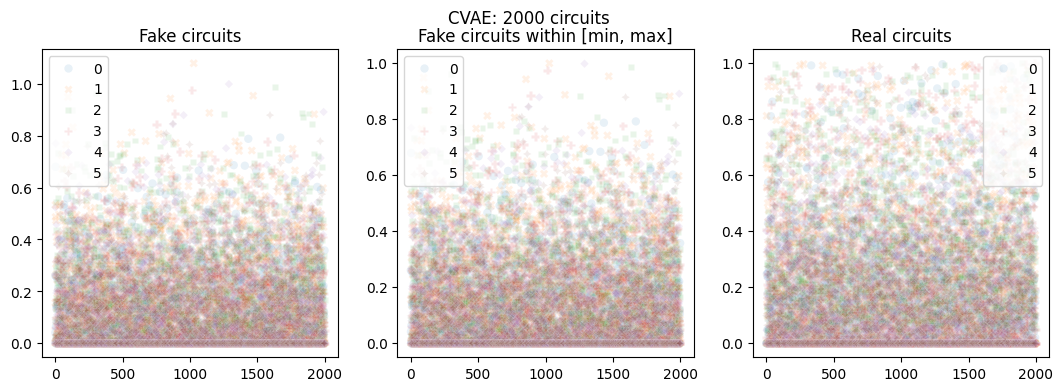

In [26]:
fig = plt.figure(figsize=(13, 4))

show_max = 2000

ax = plt.subplot(1, 3, 1)
sns.scatterplot(fake_circuits[:show_max], alpha=0.1)
plt.title('Fake circuits')

ax = plt.subplot(1, 3, 2)
fake_circuits_1 = np.where(fake_circuits[:show_max] > x.max(), x.max(), fake_circuits[:show_max])
sns.scatterplot(np.where(fake_circuits_1 < x.min(), x.min(), fake_circuits_1), alpha=0.1)
plt.title('Fake circuits within [min, max]')

ax = plt.subplot(1, 3, 3)
sns.scatterplot(
    x.reshape(np.prod(x.shape[:-1]), x.shape[-1])[:show_max], alpha=0.1)
plt.title('Real circuits')

plt.suptitle(f'CVAE: {show_max} circuits')
plt.show()


## Conditionality

In [27]:
n_obj = len(config_dataset.objective_col)
n_categories = 5 if not config_norm_y.categorical_onehot else config_norm_y.categorical_n_bins
if tuple(config_dataset.objective_col) == ('Log sensitivity > 0', 'Log precision > 1'):
    n_categories = 2
n_to_sample_per_cat = int(1e3)
print('Total to sample: ', n_categories ** n_obj * n_to_sample_per_cat)
n_to_sample = n_categories ** n_obj * n_to_sample_per_cat  # int(1e6)

Total to sample:  25000


In [28]:
fake_circuits, z, sampled_cond = sample_reconstructions(p, PRNG, decoder, n_categories, n_to_sample, hidden_size=config_model.hidden_size,
                                                        x_datanormaliser=x_datanormaliser, x_methods_preprocessing=x_methods_preprocessing, objective_cols=config_dataset.objective_col,
                                                        use_binned_sampling=config_norm_y.categorical, use_onehot=config_norm_y.categorical_onehot)
# if config_norm_y.categorical_onehot:
#     sampled_cond = np.repeat(np.arange(config_norm_y.categorical_n_bins)[
#                              :, None], repeats=n_to_sample, axis=1)
#     sampled_cond = jax.nn.one_hot(
#         sampled_cond, config_norm_y.categorical_n_bins)
#     for k in config_dataset.objective_col[1:]:
#         sampled_cond2 = np.repeat(np.arange(config_norm_y.categorical_n_bins)[
#                                   :, None], repeats=n_to_sample, axis=1)
#         sampled_cond2 = jax.nn.one_hot(
#             sampled_cond2, config_norm_y.categorical_n_bins)
#         sampled_cond = np.concatenate([sampled_cond, sampled_cond2], axis=-1)
# else:
#     sampled_cond_nonrepeated = np.array(list(itertools.product(
#         *([np.linspace(cond.min(), cond.max(), n_categories).tolist()] * n_obj))))
#     sampled_cond = np.repeat(sampled_cond_nonrepeated, repeats=n_to_sample, axis=1).reshape(
#         n_categories ** n_obj, n_to_sample, n_obj)
#     # sampled_cond = np.repeat(s[:, :, None], repeats=n_to_sample, axis=2)
#     # s = np.repeat(np.linspace(cond.min(), cond.max(), n_categories)[:, None], repeats=n_to_sample, axis=1)[:, :, None]
# z = jax.random.normal(PRNG, (n_categories ** n_obj,
#                       n_to_sample, config_model.hidden_size))
# z = np.concatenate([z, sampled_cond], axis=-1)

# fake_circuits = jax.vmap(partial(decoder, params=p, rng=PRNG))(inputs=z)

# fake_circuits = fake_circuits.reshape(np.prod(fake_circuits.shape[:-1]), fake_circuits.shape[-1])
# sampled_cond = sampled_cond.reshape(np.prod(sampled_cond.shape[:-1]), sampled_cond.shape[-1])
fake_circuits.shape, sampled_cond.shape

((25, 1000, 6), (25, 1000, 2))

In [29]:
# # sns.histplot(decoder(p, PRNG, z).flatten(), bins=50)
# sns.histplot(fake_circuits.flatten(), bins=50, element='step')
# plt.title('Fake circuits params')

In [30]:
# n_show_max = 10
# ncols = 2
# nrows = n_show_max // ncols + 1
# for k in config_dataset.objective_col:

#     fig = plt.figure(figsize=(10*ncols, 5*nrows))
#     show_max = 300 #n_to_sample
#     widest_lim = [0, 0]
#     for i, (zi, cat) in enumerate(zip(z[:n_show_max], fake_circuits[:n_show_max])):
#         ax = plt.subplot(nrows, ncols, i+1)
#         # g = sns.scatterplot(cat[:show_max])
#         g = sns.histplot(cat, element='step', bins=30, palette='viridis', multiple='fill')
#         if config_norm_y.categorical_onehot:
#             plt.title(f'Fake circuit: {k} = {y_datanormaliser.metadata[k]["category_map"][i]:.2f}')
#         else:
#             plt.title(f'Fake circuit: {k} = {str(sampled_cond_nonrepeated[i])}')
#         sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
#         widest_lim[0] = np.min([g.get_xlim()[0], widest_lim[0]])
#         widest_lim[1] = np.max([g.get_xlim()[1], widest_lim[1]])
#         g.set_xlim(widest_lim)

#     break
# plt.suptitle(f'CVAE: fake circuits ({config_dataset.objective_col})')

## Compare to real circuit's objective

In [31]:
def apply_fns(x, fns: list):
    og_shape = x.shape
    if x.ndim > 2:
        x = x.reshape(*(np.prod(x.shape[:-1]), x.shape[-1]))
    for fcn in fns:
        x = fcn(x)
    return x.reshape(og_shape)

for k in config_dataset.objective_col:
    df = df[~df[k].isna()]
    df[k + '_nearest_edge'] = bin_to_nearest_edge(df[k].to_numpy(), n_bins=n_categories)
    
    # Create bins based on quartiles for each objective column
    # quartiles = df[k].quantile(np.arange(0, 1+1/n_categories, 1/n_categories))
    # df[k + '_nearest_quartile'] = pd.cut(df[k], bins=quartiles).apply(lambda x: x.mid)
# fake_circuits = x_datanormaliser.create_chain_preprocessor_inverse(x_methods_preprocessing)(fake_circuits)


In [32]:
# for k in config_dataset.objective_col:
#     fig = plt.figure(figsize=(10*2, 5*5))
#     show_max = 300 #n_to_sample
#     widest_lim = [0, 0]
#     for i, edge in enumerate(sorted(df[k + '_nearest_edge'].unique())):
#         cat = df[df[k + '_nearest_edge'] == edge]
#         cat = cat[x_cols].to_numpy()
        
#         ax = plt.subplot(5, 2, i+1)
#         # g = sns.scatterplot(cat[:show_max])
#         g = sns.histplot(cat, element='step', bins=30, palette='magma', multiple='fill')
#         plt.title(f'Real circuit: {k} = {str(edge)[:6]}')
#         sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
#         widest_lim[0] = np.min([g.get_xlim()[0], widest_lim[0]])
#         widest_lim[1] = np.max([g.get_xlim()[1], widest_lim[1]])
#         g.set_xlim(widest_lim)
        
#     break

# plt.suptitle(f'CVAE: real circuits {config_dataset.objective_col}')

## Combined

In [33]:
def combine_masks(l: list):
    combined_mask = np.ones(len(df), dtype=bool)
    for mask in l:
        combined_mask &= mask
    return combined_mask


if len(config_dataset.objective_col) > 1:
    sampled_cond_inverse = sampled_cond.mean(axis=1)
else:
    sampled_cond_inverse = np.array(sorted(np.unique(sampled_cond)))[:, None]

for ii, (k, sc_i) in enumerate(zip(config_dataset.objective_col, sampled_cond_inverse.T)):
    sc_i = y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(sc_i, col=k)
    sampled_cond_inverse[..., ii] = sc_i


In [34]:
n_objs = len(config_dataset.objective_col)

if n_objs > 2:
    n_min_real = 10
    n_plots_max = 24
    n_max_show = n_plots_max//2
    ncols = 6
    nrows = 4
    
    obj_col_nearest_all = np.array(list(itertools.product(*[sorted(df[k + '_nearest_edge'].unique().tolist()) for k in config_dataset.objective_col])))
    # obj_col_nearest_all = obj_col_nearest_all.reshape(*[n_objs] * n_objs, n_categories)
    uagg = df.groupby(by=[k + '_nearest_edge'for k in config_dataset.objective_col])[x_cols].agg('count')
    obj_col_nearest_existing = np.array(uagg[uagg > n_min_real].dropna().sort_values(by=x_cols, ascending=False).iloc[:n_max_show].index.to_list())
    rng = jax.random.PRNGKey(0)
    # idxs_subsample = jax.random.choice(rng, np.arange(len(obj_col_nearest_existing)), shape=(min(n_plots_max//2, len(obj_col_nearest_existing)),), replace=False)
    # obj_col_nearest_existing = obj_col_nearest_existing[idxs_subsample]

    idxs_existing = np.where(jax.vmap(lambda x: x == obj_col_nearest_all)(obj_col_nearest_existing).sum(axis=-1) >= n_objs)
    
    idxs_existing_r = idxs_existing[0]
    idxs_existing_f = idxs_existing[1]

    # ncols = int(np.ceil(np.sqrt(len(idxs_subsample))) * 2)
    # nrows = int(np.ceil(np.sqrt(len(idxs_subsample))))
    fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), sharex=True, sharey=True)
    for i, (zi, fake, edges) in enumerate(zip(z[idxs_existing_f], fake_circuits[idxs_existing_f], obj_col_nearest_existing[idxs_existing_r])):
        ax_l = axs[i % nrows, 2 * (i // nrows)]
        ax_r = axs[i % nrows, 2 * (i // nrows) + 1]
        widest_lim = [0, 0]
        mask_edge = combine_masks([df[k + '_nearest_edge'] == edges[ii] for ii, k in enumerate(config_dataset.objective_col)])
        real = df[mask_edge][x_cols].to_numpy()
        
        g1 = sns.histplot(fake, element='step', bins=30, palette='viridis', multiple='fill', ax=ax_l)
        if config_norm_y.categorical_onehot:
            ax_l.set_title(f'{len(fake)} fake circuits\n{k} = {y_datanormaliser.metadata[k]["category_map"][i]:.2f}')
        else:
            text_obj_col = ', '.join([f'{sampled_cond_inverse[idxs_existing_f][i][ii]:.2f}' for ii, k in enumerate(config_dataset.objective_col)])
            ax_l.set_title(f'{len(fake)} fake circuits\n{text_obj_col}')
        sns.move_legend(g1, 'upper left', bbox_to_anchor=(1, 1))
        
        
        if not real.size:
            continue
        g2 = sns.histplot(real, element='step', bins=30, palette='magma', multiple='fill', ax=ax_r)
        sns.move_legend(g2, 'upper left', bbox_to_anchor=(1, 1))
        
        if config_norm_y.categorical_onehot:
            ax_r.set_title(f'{len(real)} real circuits\n{k} = {str(edges)[:6]}')
        else:
            text_obj_col2 = ', '.join([f'{edges[ii]:.2f}' for ii, k in enumerate(config_dataset.objective_col)])
            ax_r.set_title(f'{len(real)} real circuits\n{text_obj_col2}')
        sns.move_legend(g1, 'upper left', bbox_to_anchor=(1, 1))
        
        widest_lim = [np.min([g1.get_xlim()[0], g2.get_xlim()[0], widest_lim[0]]), np.max([g1.get_xlim()[1], g2.get_xlim()[1], widest_lim[1]])]
        g1.set_xlim(widest_lim)
        g2.set_xlim(widest_lim)


    plt.suptitle(f'CVAE: circuit comparison fake vs. real\n{", ".join(config_dataset.objective_col)}', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [35]:
if n_objs > 2:
    fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), sharex=True, sharey=True)
    for i, (zi, fake, edges) in enumerate(zip(z[idxs_existing_f], fake_circuits[idxs_existing_f], obj_col_nearest_existing[idxs_existing_r])):
        ax_l = axs[i % nrows, 2 * (i // nrows)]
        ax_r = axs[i % nrows, 2 * (i // nrows) + 1]
        widest_lim = [0, 0]
        mask_edge = combine_masks([df[k + '_nearest_edge'] == edges[ii] for ii, k in enumerate(config_dataset.objective_col)])
        real = df[mask_edge][x_cols].to_numpy()
        
        g1 = sns.histplot(fake, element='step', bins=30, palette='viridis', multiple='layer', fill=False, log_scale=[False, True], ax=ax_l)
        if config_norm_y.categorical_onehot:
            ax_l.set_title(f'{len(fake)} fake circuits\n{k} = {y_datanormaliser.metadata[k]["category_map"][i]:.2f}')
        else:
            text_obj_col = ', '.join([f'{sampled_cond_inverse[idxs_existing_f][i][ii]:.2f}' for ii, k in enumerate(config_dataset.objective_col)])
            ax_l.set_title(f'{len(fake)} fake circuits\n{text_obj_col}')
        sns.move_legend(g1, 'upper left') #, bbox_to_anchor=(1, 1))
        
        
        if not real.size:
            continue
        g2 = sns.histplot(real, element='step', bins=30, palette='magma', multiple='layer', fill=False, log_scale=[False, True], ax=ax_r)
        sns.move_legend(g2, 'upper left') #, bbox_to_anchor=(1, 1))
        
        if config_norm_y.categorical_onehot:
            ax_r.set_title(f'{len(real)} real circuits\n{k} = {str(edges)[:6]}')
        else:
            text_obj_col2 = ', '.join([f'{edges[ii]:.2f}' for ii, k in enumerate(config_dataset.objective_col)])
            ax_r.set_title(f'{len(real)} real circuits\n{text_obj_col2}')
        
        widest_lim = [np.min([g1.get_xlim()[0], g2.get_xlim()[0], widest_lim[0]]), np.max([g1.get_xlim()[1], g2.get_xlim()[1], widest_lim[1]])]
        # g1.set_xlim(widest_lim)
        # g2.set_xlim(widest_lim)


    plt.suptitle(f'CVAE: circuit comparison fake vs. real\n{", ".join(config_dataset.objective_col)}', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

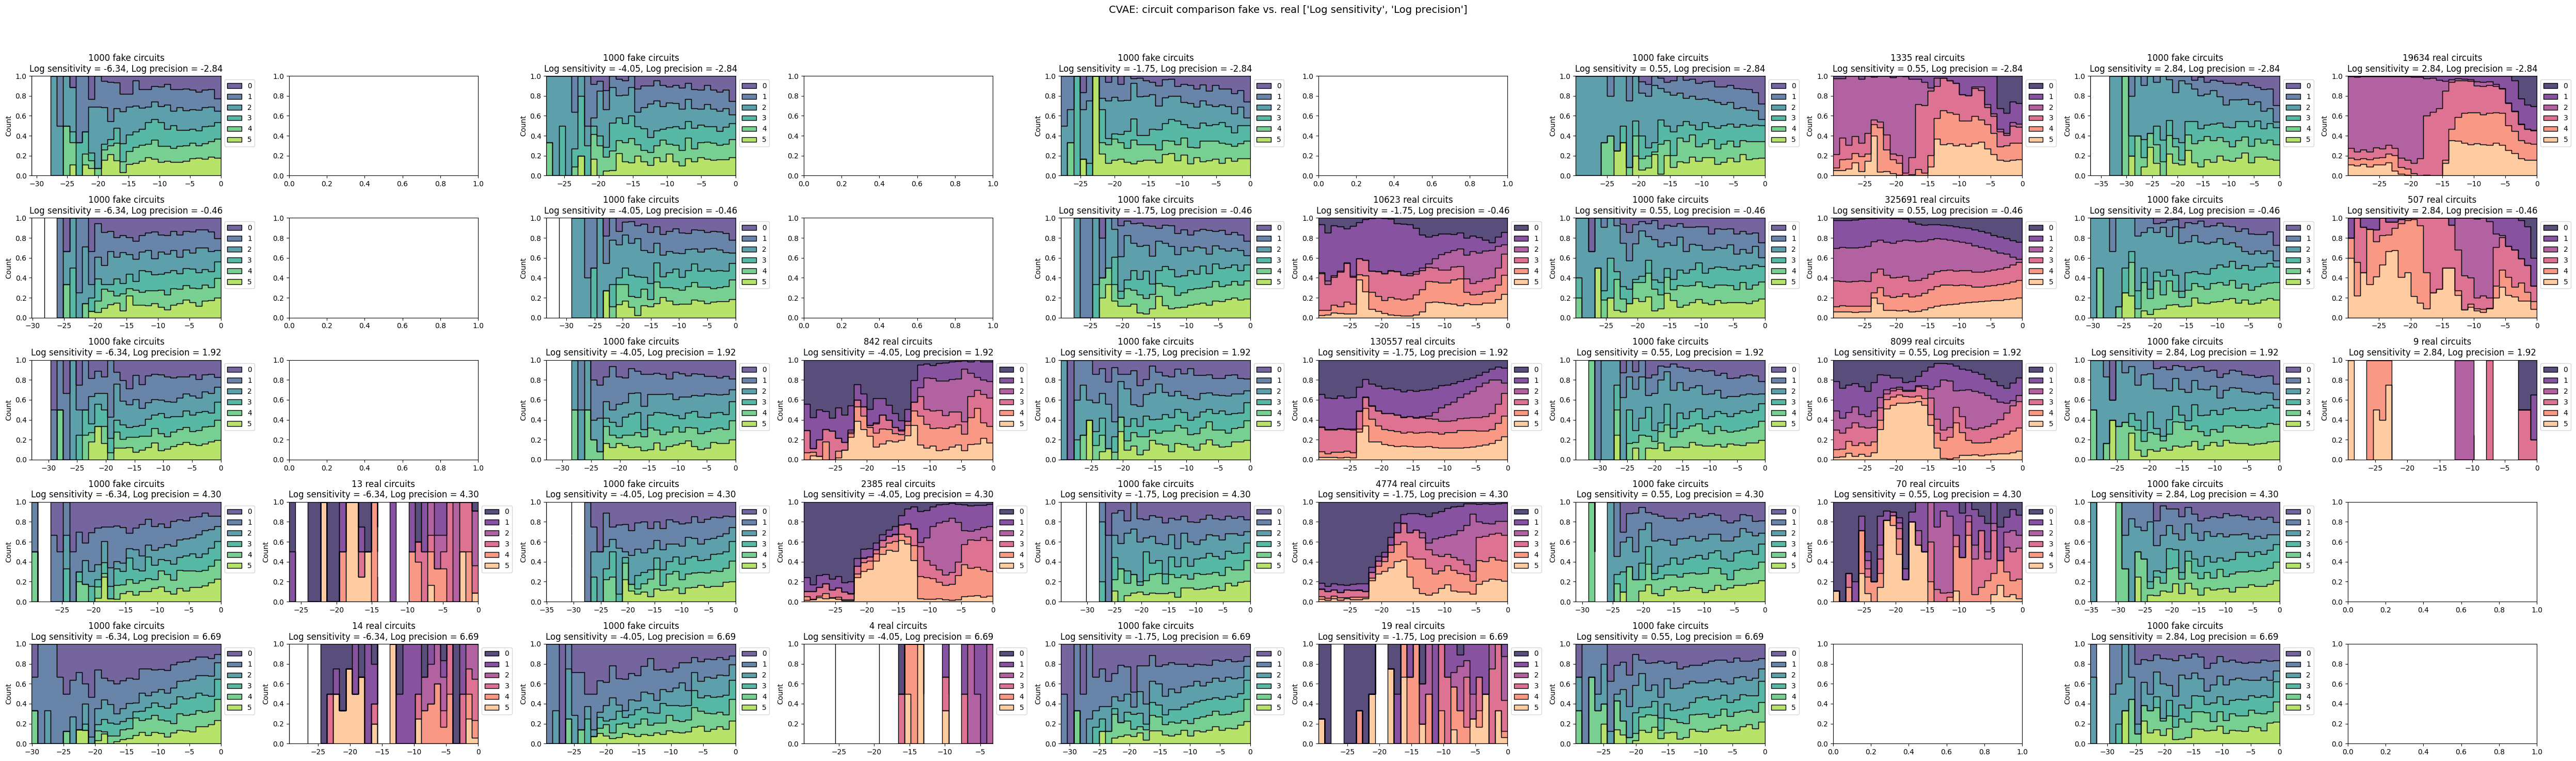

In [36]:
if n_objs <= 2:
    obj_col_nearest = list(itertools.product(*[sorted(df[k + '_nearest_edge'].unique().tolist()) for k in config_dataset.objective_col]))
    nrows = n_categories
    ncols = n_categories ** (len(config_dataset.objective_col) - 1) * 2
    fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, nrows*3))
    show_max = 300 #n_to_sample
    for i, (zi, fake, edges) in enumerate(zip(z, fake_circuits, obj_col_nearest)):
        ax_l = axs[i % nrows, ((2 * i) // ncols) * 2]
        ax_r = axs[i % nrows, ((2 * i) // ncols) * 2 + 1]
        widest_lim = [0, 0]
        mask_edge = combine_masks([df[k + '_nearest_edge'] == edges[ii] for ii, k in enumerate(config_dataset.objective_col)])
        real = df[mask_edge][x_cols].to_numpy()
        
        g1 = sns.histplot(fake, element='step', bins=30, palette='viridis', multiple='fill', ax=ax_l)
        if config_norm_y.categorical_onehot:
            ax_l.set_title(f'{len(fake)} fake circuits\n{k} = {y_datanormaliser.metadata[k]["category_map"][i]:.2f}')
        else:
            text_obj_col = ', '.join([k + ' = ' + f'{sampled_cond_inverse[i][ii]:.2f}' for ii, k in enumerate(config_dataset.objective_col)])
            if len(text_obj_col) > 50:
                text_obj_col = text_obj_col.replace(', ', ',\n')
            ax_l.set_title(f'{len(fake)} fake circuits\n{text_obj_col}')
        sns.move_legend(g1, 'upper left', bbox_to_anchor=(1, 1))
        
        
        if not real.size:
            continue
        g2 = sns.histplot(real, element='step', bins=30, palette='magma', multiple='fill', ax=ax_r)
        sns.move_legend(g2, 'upper left', bbox_to_anchor=(1, 1))
        
        if config_norm_y.categorical_onehot:
            ax_r.set_title(f'{len(real)} real circuits\n{k} = {str(edges)[:6]}')
        else:
            text_obj_col2 = ', '.join([k + ' = ' + f'{edges[ii]:.2f}' for ii, k in enumerate(config_dataset.objective_col)])
            if len(text_obj_col2) > 50:
                text_obj_col2 = text_obj_col2.replace(', ', ',\n')
            ax_r.set_title(f'{len(real)} real circuits\n{text_obj_col2}')
        sns.move_legend(g1, 'upper left', bbox_to_anchor=(1, 1))
        
        widest_lim = [np.min([g1.get_xlim()[0], g2.get_xlim()[0], widest_lim[0]]), np.max([g1.get_xlim()[1], g2.get_xlim()[1], widest_lim[1]])]
        # g1.set_xlim(widest_lim)
        # g2.set_xlim(widest_lim)


    plt.suptitle(f'CVAE: circuit comparison fake vs. real {config_dataset.objective_col}', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


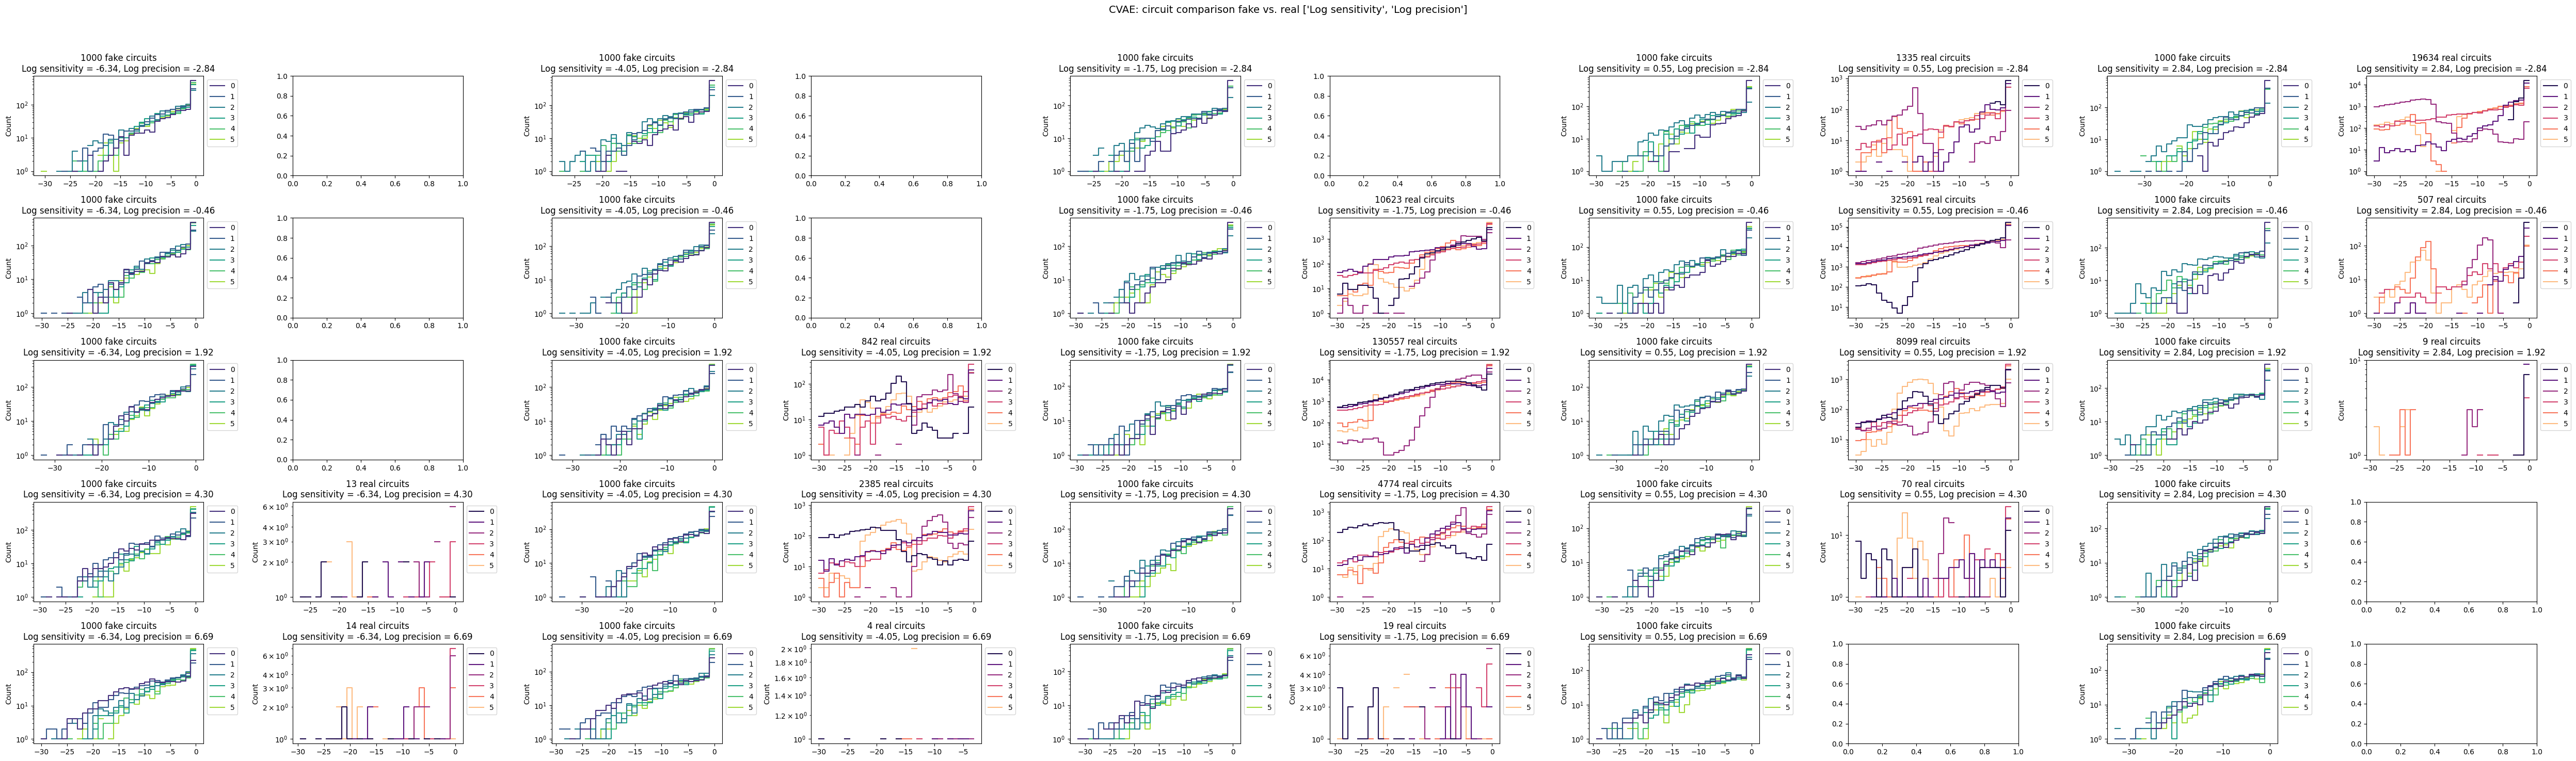

In [37]:
if n_objs <= 2:
    obj_col_nearest = list(itertools.product(*[sorted(df[k + '_nearest_edge'].unique().tolist()) for k in config_dataset.objective_col]))
    nrows = n_categories
    ncols = n_categories ** (len(config_dataset.objective_col) - 1) * 2
    fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, nrows*3))
    show_max = 300 #n_to_sample
    for i, (zi, fake, edges) in enumerate(zip(z, fake_circuits, obj_col_nearest)):
        ax_l = axs[i % nrows, ((2 * i) // ncols) * 2]
        ax_r = axs[i % nrows, ((2 * i) // ncols) * 2 + 1]
        widest_lim = [0, 0]
        mask_edge = combine_masks([df[k + '_nearest_edge'] == edges[ii] for ii, k in enumerate(config_dataset.objective_col)])
        real = df[mask_edge][x_cols].to_numpy()
        
        g1 = sns.histplot(fake, element='step', bins=30, palette='viridis', multiple='layer', fill=False, log_scale=[False, True], ax=ax_l)
        if config_norm_y.categorical_onehot:
            ax_l.set_title(f'{len(fake)} fake circuits\n{k} = {y_datanormaliser.metadata[k]["category_map"][i]:.2f}')
        else:
            text_obj_col = ', '.join([k + ' = ' + f'{sampled_cond_inverse[i][ii]:.2f}' for ii, k in enumerate(config_dataset.objective_col)])
            ax_l.set_title(f'{len(fake)} fake circuits\n{text_obj_col}')
        sns.move_legend(g1, 'upper left', bbox_to_anchor=(1, 1))
        
        
        if not real.size:
            continue
        g2 = sns.histplot(real, element='step', bins=30, palette='magma', multiple='layer', fill=False, log_scale=[False, True], ax=ax_r)
        sns.move_legend(g2, 'upper left', bbox_to_anchor=(1, 1))
        
        if config_norm_y.categorical_onehot:
            ax_r.set_title(f'{len(real)} real circuits\n{k} = {str(edges)[:6]}')
        else:
            text_obj_col2 = ', '.join([k + ' = ' + f'{edges[ii]:.2f}' for ii, k in enumerate(config_dataset.objective_col)])
            ax_r.set_title(f'{len(real)} real circuits\n{text_obj_col2}')
        sns.move_legend(g1, 'upper left', bbox_to_anchor=(1, 1))
        
        widest_lim = [np.min([g1.get_xlim()[0], g2.get_xlim()[0], widest_lim[0]]), np.max([g1.get_xlim()[1], g2.get_xlim()[1], widest_lim[1]])]
        # g1.set_xlim(widest_lim)
        # g2.set_xlim(widest_lim)


    plt.suptitle(f'CVAE: circuit comparison fake vs. real {config_dataset.objective_col}', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


## Quick UMAP

In [38]:
perplexity = 30
n_show = 3000
random_state = 0
rng_key = jax.random.PRNGKey(0)  # Initialize a PRNG key with a seed

input_species = data['sample_name'].dropna().unique()

def bin_array(data, num_bins=10):
    original_shape = data.shape
    flattened_data = data.flatten()
    bin_edges = np.linspace(flattened_data.min(), flattened_data.max(), num_bins + 1)
    bin_means = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(num_bins)]
    bin_indices = np.clip(np.digitize(flattened_data, bin_edges) - 1, 0, num_bins - 1)
    binned_data = np.array([bin_means[idx] for idx in bin_indices])
    binned_data = binned_data.reshape(original_shape)
    bin_labels = [f"Bin {i}: [{bin_edges[i]:.2f}, {bin_edges[i+1]:.2f}), Mean: {bin_means[i]:.2f}"
                 for i in range(num_bins)]
    return binned_data, bin_edges, bin_labels

h_all = encoder(p, rng, np.concatenate([x, cond], axis=-1))
h_all = h_all.reshape(np.prod(h_all.shape[:-1]), -1)

cond_rev_all = np.concatenate([y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(
    cond[..., i], col=c).flatten() for i, c in enumerate(config_dataset.objective_col)]).reshape(np.prod(cond.shape[:-1]), -1).squeeze()
# cond_rev_all = y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(cond, col=config_dataset.objective_col[0]).reshape(np.prod(cond.shape[:-1]), -1).squeeze()
x_rev_all = x_datanormaliser.create_chain_preprocessor_inverse(x_methods_preprocessing)(x).reshape(np.prod(x.shape[:-1]), -1).squeeze()

x_bin_all, edges, labels = bin_array(x_rev_all, num_bins=10)
x_bin_all = np.round(x_bin_all, 1)

cond_binned = cond
if not hpos_all['prep_y_categorical']:
    cond_binned = bin_array(
        cond_rev_all, num_bins=hpos_all['prep_y_categorical_n_bins'])[0]

cond_unique = [np.unique(cond_binned[..., i]) for i in range(cond_binned.shape[-1])]
cond_unique = np.array(list(itertools.product(*cond_unique)))

idxs_show = []
for c in cond_unique:
    idxs_show.extend(np.where((cond_binned != c).sum(axis=-1) == 0)[0][:np.max([n_show//len(cond_unique), 5])])
idxs_show = np.array(idxs_show)
if len(idxs_show) > n_show:
    idxs_show = jax.random.choice(rng_key, idxs_show, (n_show,), replace=False)
    
reducer_umap = umap.UMAP(n_neighbors=100, n_components=2, random_state=random_state,
                         #  metric='euclidean', n_epochs=2000, learning_rate=0.1, init='spectral')
                         metric='euclidean', n_epochs=2000, learning_rate=0.1, init='pca')
umap_result = reducer_umap.fit_transform(h_all[idxs_show])


def visualize_dimred_2d_custom_labels(tsne_result_2, cond, x_bin, labels_cond, labels_x: list, method='TSNE'):
    ncols = 4
    nrows = len(labels_cond)
    fig, axes = plt.subplots(nrows, ncols, figsize=(
        20, 4*nrows), sharex=True, sharey=True)

    # Cond plots on the left
    for i, l in enumerate(labels_cond):
        ax_main = fig.add_subplot(axes[i, 0])  # Span both rows
        scatter = ax_main.scatter(
            tsne_result_2[:, 0], tsne_result_2[:, 1], c=cond[:, i], cmap='viridis', alpha=0.5)
        ax_main.set_title(
            f'{method} clusters {l}', fontsize=14)
        ax_main.set_xlabel(f'{method} Dimension 1', fontsize=12)
        ax_main.set_ylabel(f'{method} Dimension 2', fontsize=12)
        plt.colorbar(scatter, ax=ax_main, label=l)

    # Interaction plots on the right
    for i in range(x_bin.shape[-1]):
        row = i // (ncols-1)
        col = i % (ncols-1) + 1
        ax = fig.add_subplot(axes[row, col])
        scatter = ax.scatter(
            tsne_result_2[:, 0], tsne_result_2[:, 1], c=x_bin[:, i], cmap='plasma', alpha=0.5)
        ax.set_title(' + '.join(labels_x[i]), fontsize=14)
        ax.set_xlabel(f'{method} Dimension 1', fontsize=12)
        ax.set_ylabel(f'{method} Dimension 2', fontsize=12)
        # if i == (x_bin.shape[-1] - 1):
        plt.colorbar(scatter, ax=ax, label=f'Energy (kcal/mol)')

    plt.suptitle(f'{method} visualization of latent space', fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # plt.savefig(os.path.join(top_write_dir, 'tsne2_custom.png'), dpi=300)
    plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


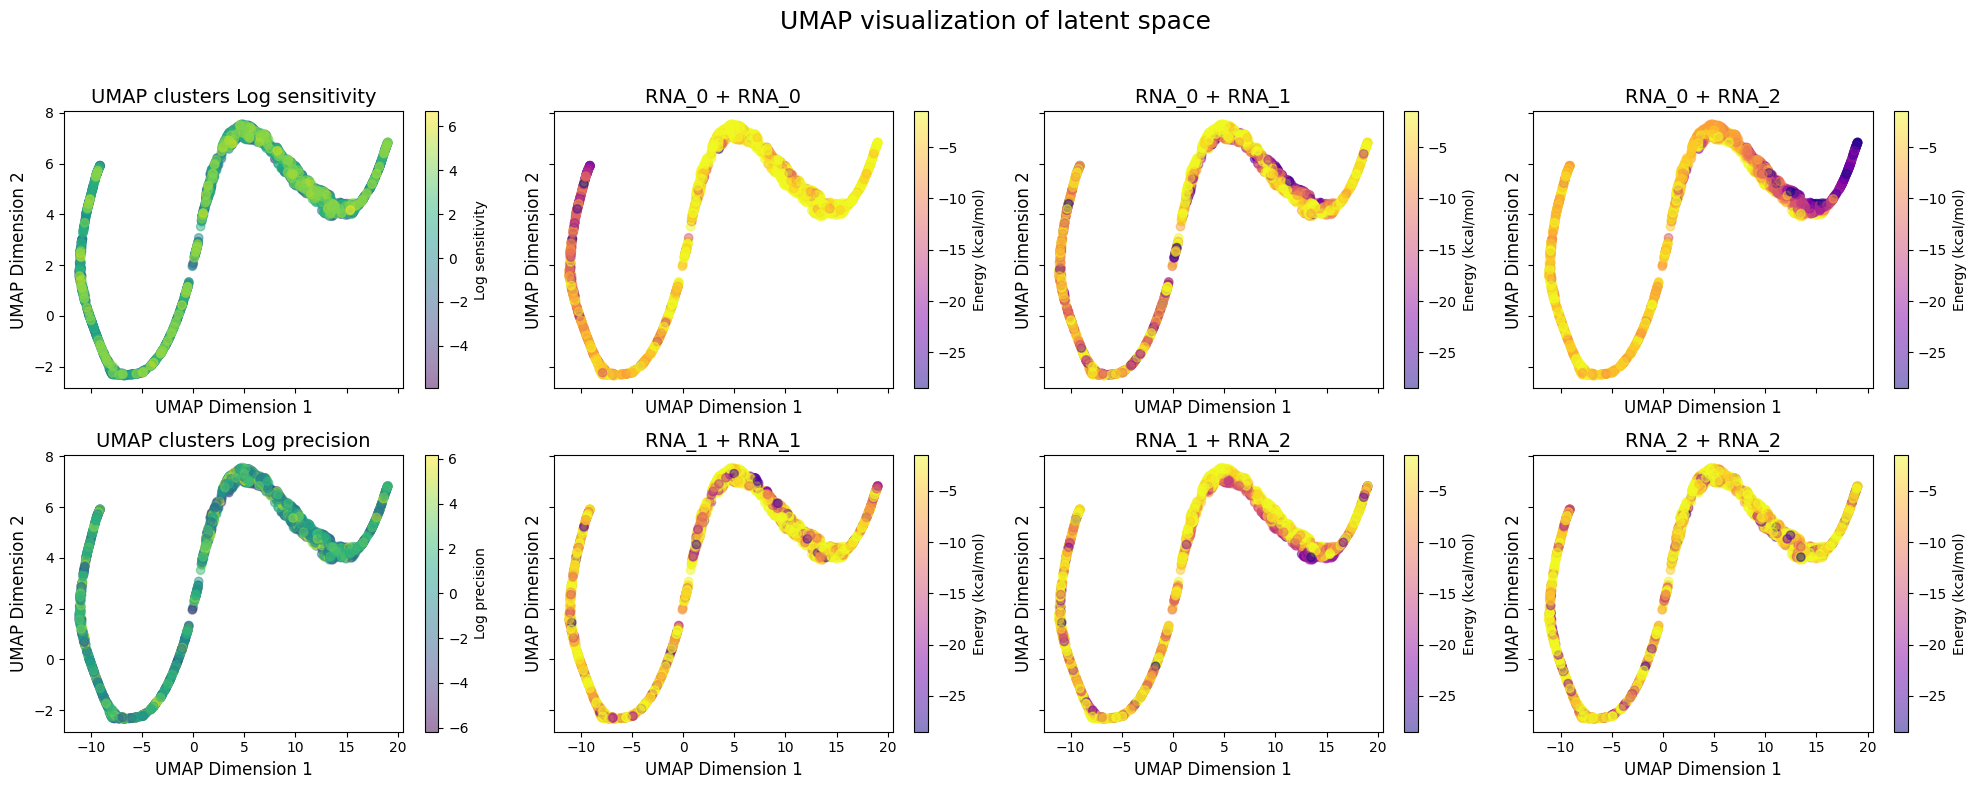

In [39]:
labels_x = list(itertools.product(input_species, input_species))
labels_x = sorted(set(tuple(sorted(labels_x[i])) for i in range(len(labels_x))))
visualize_dimred_2d_custom_labels(umap_result, cond_rev_all[idxs_show], x_bin_all[idxs_show],
                           labels_cond=config_dataset.objective_col, 
                           labels_x=labels_x, method='UMAP')
